In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import folium
from folium import plugins 
from folium.plugins import HeatMap

import geopy.distance as geodist

In [2]:
pd.set_option('display.max_columns', None)
init_notebook_mode(connected = True)
sns.set_style('darkgrid')

In [6]:
df = pd.read_pickle('df_features.pickle')

In [5]:
# Check first and last date
print('First date recorded is: {}'.format(df.starttime.min()))
print('Last date recorded is: {}'.format(df.starttime.max()))

First date recorded is: 2015-01-01 00:07:00
Last date recorded is: 2017-12-31 23:58:00


In [6]:
# Check the distribution percentages based on years
round(df.starttime.dt.year.value_counts(normalize = True) * 100, 1)

2017    37.1
2016    34.1
2015    28.8
Name: starttime, dtype: float64

In [7]:
print('The new length of the dataframe is: {} records'.format(len(df)))
print('The new memory usage is: {} GB'.format(round(df.memory_usage(deep= True).sum() / 1000 ** 3, 2)))

The new length of the dataframe is: 6680215 records
The new memory usage is: 0.44 GB


### Extract Datetime Features

In [6]:
df['hour'] = df.starttime.dt.hour.astype('int8')
df['year'] = df.starttime.dt.year.astype('int16')
df['month'] = df.starttime.dt.month.astype('int8')   # if [month_name], it has to follow with '()'
df['weekday'] = df.starttime.dt.weekday.astype('int8')

In [50]:
holidays = ['2015-01-01', '2015-12-25', '2015-11-11', '2015-07-04', '2015-01-19', '2015-02-16', '2015-03-02', '2015-05-25', 
            '2015-09-07', '2015-10-12', '2015-11-26', '2016-01-01', '2016-12-25', '2016-11-11', '2016-07-04', '2016-01-18', 
            '2016-02-15', '2016-03-04', '2016-05-30', '2016-09-05', '2016-10-10', '2016-11-24', '2017-01-01', '2017-12-25', 
            '2017-11-11', '2017-07-04', '2017-01-16', '2017-02-20', '2017-03-06', '2017-05-29', '2017-09-04', '2017-10-09', '2017-11-23' ]

# Identify holidays
df['is_holiday'] = df.starttime.dt.date.astype('str').isin(holidays)

# Identify weekends (Saurday & Sunday)
weekends_list = [5, 6]
df['is_weekends'] = df.weekday.isin(weekends_list)

### Extract Seasons

In [31]:
def seasons(x):
    
    spring = [3,4,5]
    summer = [6,7,8]
    fall   = [9,10,11]
    winter = [12,1,2]
    
    if x in spring:
        return 1
    elif x in summer:
        return 2
    elif x in fall:
        return 3
    elif x in winter:
        return 4

# 1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'
df['seasons'] = df.month.apply(lambda x: seasons(x))

### Conversions
- Convert visibility from mile to km
- Convert wind speed from mile to km
- Convert trip duration from seconds to minutes
- convert temperature from f to c

In [10]:
df.visibility = df.visibility.apply(lambda x: int(x / 0.621371))
df.wind_speed = df.wind_speed.apply(lambda x: int(x / 0.621371))
df.new_tripduration = df.new_tripduration.apply(lambda x: int(x / 60))
df.temperature = df.temperature.apply(lambda x: int(round((x - 32) * 5 / 9)))

### Create new feature for trip dutation in hours

In [61]:
df['duration_inhour'] = round(df.new_tripduration / 60, 2)

### Unifying Station's LAT & LON  

In [5]:
# Stations with more than LAT & LON
unique_stations = [ ['900 W Harrison St'                     ,41.8747,         -87.6500],
                    ['Aberdeen St & Monroe St'               ,41.8804,         -87.6556],
                    ['Ashland Ave & Division St'             ,41.9034,         -87.6677],
                    ['Western Ave & Winnebago Ave'           ,41.9154,         -87.6872],
                    ['Wilton Ave & Diversey Pkwy'            ,41.9324,         -87.6527],
                    ['Wood St & Hubbard St'                  ,41.8896,         -87.6720],
                    ['Avers Ave & Belmont Ave'               ,41.9394,         -87.7236],
                    ['Broadway & Argyle St'                  ,41.9730,         -87.6596],
                    ['Broadway & Cornelia Ave'               ,41.9455,         -87.6464],
                    ['Broadway & Waveland Ave'               ,41.9491,         -87.6486],
                    ['Broadway & Wilson Ave'                 ,41.9652,         -87.6581],
                    ['Buckingham Fountain'                   ,41.8723,         -87.6241],
                    ['California Ave & Altgeld St'           ,41.9266,         -87.6979],
                    ['Canal St & Jackson Blvd'               ,41.8772,         -87.6394],
                    ['Canal St & Taylor St'                  ,41.8537,         -87.6351],
                    ['Central St & Girard Ave'               ,42.0640,         -87.6860],
                    ['Cityfront Plaza Dr & Pioneer Ct'       ,41.8903,         -87.6221],
                    ['Clark St & Bryn Mawr Ave'              ,41.9836,         -87.6692],
                    ['Clark St & Elm St'                     ,41.9030,         -87.6313],
                    ['Clark St & Lunt Ave'                   ,42.0091,         -87.6742],
                    ['Clark St & Winnemac Ave'               ,41.9733,         -87.6677],
                    ['Clifton Ave & Lawrence Ave'            ,41.9688,         -87.6577],
                    ['Clinton St & Jackson Blvd'             ,41.8772,         -87.6394],
                    ['Clinton St & Lake St'                  ,41.8855,         -87.6413],
                    ['Clybourn Ave & Division St'            ,41.9045,         -87.6405],
                    ['Daley Center Plaza'                    ,41.8842,         -87.6296],
                    ['Damen Ave & Augusta Blvd'              ,41.8991,         -87.6772],
                    ['Damen Ave & Division St'               ,41.9033,         -87.6784],
                    ['Drake Ave & Addison St'                ,41.9468,         -87.7164],
                    ['Elston Ave & Wabansia Ave'             ,41.9067,         -87.6828],
                    ['Fairfield Ave & Roosevelt Rd'          ,41.8666,         -87.6956],
                    ['Forest Ave & Chicago Ave'              ,41.8941,         -87.8004],
                    ['Franklin St & Monroe St'               ,41.8803,         -87.6352],
                    ['Green St & Randolph St'                ,41.8837,         -87.6487],
                    ['Halsted St & 37th St'                  ,41.8271,         -87.6458],
                    ['Halsted St & Diversey Pkwy'            ,41.9333,         -87.6487],
                    ['Halsted St & Maxwell St'               ,41.8646,         -87.6469],
                    ['Halsted St & Roosevelt Rd'             ,41.8659,         -87.6466],
                    ['Humboldt Dr & Luis Munoz Marin Dr'     ,41.8994,         -87.6964],
                    ['Humphrey Ave & Ontario St'             ,41.8902,         -87.7783],
                    ['Indiana Ave & 26th St'                 ,41.8454,         -87.6222],
                    ['Jeffery Blvd & 71st St'                ,41.7666,         -87.5765],
                    ['Keeler Ave & Irving Park Rd'           ,41.9538,         -87.7324],
                    ['Kimball Ave & Belmont Ave'             ,41.9394,         -87.7122],
                    ['Kingsbury St & Erie St'                ,41.8938,         -87.6419],
                    ['LaSalle St & Illinois St'              ,41.8907,         -87.6321],
                    ['Laramie Ave & Madison St'              ,41.8802,         -87.7553],
                    ['Larrabee St & Armitage Ave'            ,41.9180,         -87.6437],
                    ['Larrabee St & Webster Ave'             ,41.9218,         -87.6441],
                    ['Leavitt St & Addison St'               ,41.9467,         -87.6834],
                    ['Lincoln Ave & Waveland Ave'            ,41.9488,         -87.6753],
                    ['Lombard Ave & Garfield St'             ,41.8706,         -87.7792],
                    ['McClurg Ct & Erie St'                  ,41.8943,         -87.6174],
                    ['McClurg Ct & Illinois St'              ,41.8904,         -87.6175],
                    ['Michigan Ave & 18th St'                ,41.8578,         -87.6245],
                    ['Michigan Ave & Balbo Ave'              ,41.8723,         -87.6241],
                    ['Racine Ave & Garfield Blvd'            ,41.7942,         -87.6551],
                    ['Ritchie Ct & Banks St'                 ,41.9068,         -87.6264],
                    ['Rush St & Hubbard St'                  ,41.8900,         -87.6263],
                    ['Sedgwick St & North Ave'               ,41.9106,         -87.6386],
                    ['Sedgwick St & Schiller St'             ,41.9057,         -87.6385],
                    ['Sheffield Ave & Addison St'            ,41.9469,         -87.6544],
                    ['Sheffield Ave & Kingsbury St'          ,41.9096,         -87.6535],
                    ['Sheffield Ave & Waveland Ave'          ,41.9470,         -87.6542],
                    ['Sheffield Ave & Webster Ave'           ,41.9215,         -87.6538],
                    ['Sheffield Ave & Wellington Ave'        ,41.9363,         -87.6536],
                    ['Sheridan Rd & Buena Ave'               ,41.9584,         -87.6542],
                    ['Shields Ave & 31st St'                 ,41.8380,         -87.6340],
                    ['South Shore Dr & 67th St'              ,41.7736,         -87.5675],
                    ['Southport Ave & Clybourn Ave'          ,41.9204,         -87.6631],
                    ['Southport Ave & Wrightwood Ave'        ,41.9288,         -87.6639],
                    ['State St & Kinzie St'                  ,41.8892,         -87.6278],
                    ['University Ave & 57th St'              ,41.7915,         -87.5999],
                    ['Wabash Ave & Grand Ave'                ,41.8909,         -87.6268],
                    ['Wacker Dr & Washington St'             ,41.8831,         -87.6373],
                    ['Warren Park East'                      ,42.0045,         -87.6807],
                    ['Warren Park West'                      ,42.0018,         -87.6888],
                    ['Washtenaw Ave & Lawrence Ave'          ,41.9687,         -87.6962],
                    ['Wells St & Concord Ln'                 ,41.9121,         -87.6347],
                    ['Wells St & Huron St'                   ,41.8947,         -87.6344],
                    ['Wells St & Polk St'                    ,41.8724,         -87.6335],
                    ['Wentworth Ave & Archer Ave'            ,41.8536,         -87.6319],
                    ['Western Ave & 21st St'                 ,41.8539,         -87.6852],
                    ['Western Ave & Winnebago Ave'           ,41.9154,         -87.6872],
                    ['Wilton Ave & Diversey Pkwy'            ,41.9324,         -87.6527],
                    ['Wood St & Hubbard St'                  ,41.8896,         -87.6720], ] # Have to add , at the last []

# Assign one unique LAT & LON for each station
for station in unique_stations:
    df.loc[df.from_station_name == station[0], ['latitude_start', 'longitude_start']] = station[1], station[2]
    
for station in unique_stations:
    df.loc[df.to_station_name == station[0], ['latitude_end', 'longitude_end']] = station[1], station[2]

### LAT & LON Mid Point

In [8]:
df['mid_lat'] = round((df.latitude_start + df.latitude_end) / 2, 4)
df['mid_lon'] = round((df.longitude_start + df.longitude_end) / 2, 4)

### Extract Distance in KMs

In [9]:
# Convert pickup and dropoff points to array to retreive the distance in KM faster
temp_coordinations = df[['latitude_start', 'longitude_start','latitude_end', 'longitude_end']].values

# Create empty list to append the new distance points
dist_result = []

# Calculating the distance function
def calc():
    for i in range(0, len(temp_coordinations)):
        startpoint = (temp_coordinations[i][0], temp_coordinations[i][1])
        endpoint   = (temp_coordinations[i][2], temp_coordinations[i][3])
        dist_result.append(round(geodist.vincenty(startpoint, endpoint).km, 1))
            
# Executing the function
calc()

# Store the distance
df['distance_station'] = dist_result

Based on some articles about BikeShare in London, the average speed is 19KM/H for the riders that are using them on daily basis. I will assume the average speed is 10 KM/H, hence, the equation to calculate the distance is distance = speed * time (speed = ditance / speed)

In [105]:
# Convert trip duration to hours and multiply with 8 km/h
df['distance_trip'] = round((df.new_tripduration / 60) * 10, 1)

# Change the distance tip to distance station if from/to stations are not the same
####df.loc[df.from_station_name != df.to_station_name, 'distance_trip'] = df.loc[df.from_station_name != df.to_station_name, 'distance_station']

In [32]:
df[['dpcapacity_start', 'temperature', 'humidity', 'pressure', 'visibility', 'wind_speed', 'new_tripduration', 'distance_station', 'distance_trip']].describe().apply(lambda x: round(x, 1)) # To avoid scientific numbers like '6.680215e+06'

dpcapacity_start  temperature   humidity   pressure  visibility  \
count         6680215.0    6680215.0  6680215.0  6680215.0   6680215.0   
mean               21.9         17.6       60.7       29.5        15.3   
std                 8.0          9.4       17.2        0.5         2.6   
min                 0.0        -24.0       13.0       29.0         0.0   
25%                15.0         12.0       48.0       29.0        16.0   
50%                19.0         20.0       61.0       30.0        16.0   
75%                27.0         25.0       73.0       30.0        16.0   
max                55.0         35.0      100.0       30.0        16.0   

       wind_speed  new_tripduration  distance_station  distance_trip  
count   6680215.0         6680215.0         6680215.0      6680215.0  
mean         15.4              12.6               2.2            2.2  
std           8.2               7.0               1.4            1.4  
min           0.0               5.0               0.0            0.1  
25%           9.0               7.0               1.2            1.2  
50%          16.0              11.0               1.7            1.8  
75%          20.0              16.0               2.8            2.8  
max          67.0              60.0              21.3           21.3

In [17]:
df.loc[df.distance_station == 21.3]

usertype  gender           starttime            stoptime  \
2988503         0       0 2016-07-11 14:57:10 2016-07-12 09:39:18   

               from_station_name  latitude_start  longitude_start  \
2988503  Western Ave & Roscoe St          41.943         -87.6874   

         dpcapacity_start             to_station_name  latitude_end  \
2988503                15  Stony Island Ave & 71st St       41.7665   

         longitude_end  dpcapacity_end  temperature  humidity  pressure  \
2988503       -87.5865              11           31        53        29   

         visibility  wind_speed        events  rain     conditions  \
2988503          16          28  mostlycloudy     0  Mostly Cloudy   

         new_tripduration  year  month  weekday        wind_bins  seasons  \
2988503                29  2016      7        0  Moderate breeze        2   

         mid_lat  mid_lon  is_holiday  is_weekends  distance_station  \
2988503  41.8547  -87.637       False        False              21.3   

         distance_trip  
2988503           3.87

### Categorize Wind Speed

In [14]:
# Create bins and labels for the wind bins (starting from -1 to include the '0')
bins = [-1, 6, 12, 20, 30, 40, 51, 62, 75, 88, 102, 117, 159]
labels = ['Light air', 'Light breeze', 'Gentle breeze', 'Moderate breeze', 'Fresh breeze', 'Strong breeze', 'Moderate gale', 'Fresh gale', 'Strong gale', 'Whole gale', 'Storm', 'Hurricane']

# Categorize wind speed
df['wind_bins'] = pd.cut(df.wind_speed, bins = bins, labels = labels)

### Manually Remove Outliers Based on Date
- Remove data where dates are not the same and time is before 11:00 PM

In [83]:
#df.loc[df.distance_trip > 20]
#df.loc[df.starttime.dt.date != df.stoptime.dt.date]
#df.loc[(df.starttime.dt.date != df.stoptime.dt.date) & (df.starttime.dt.hour)]
#df.loc[df.starttime.dt.strftime('%H:%M:%S').between('23:54:00', '00:01:00')]
#len(df.loc[(df.starttime.dt.date != df.stoptime.dt.date) & (df.starttime.dt.strftime('%H:%M:%S') < '23:00:00')])
df = df.loc[~((df.starttime.dt.date != df.stoptime.dt.date) & (df.starttime.dt.strftime('%H:%M:%S') < '23:00:00'))]

## Clustering

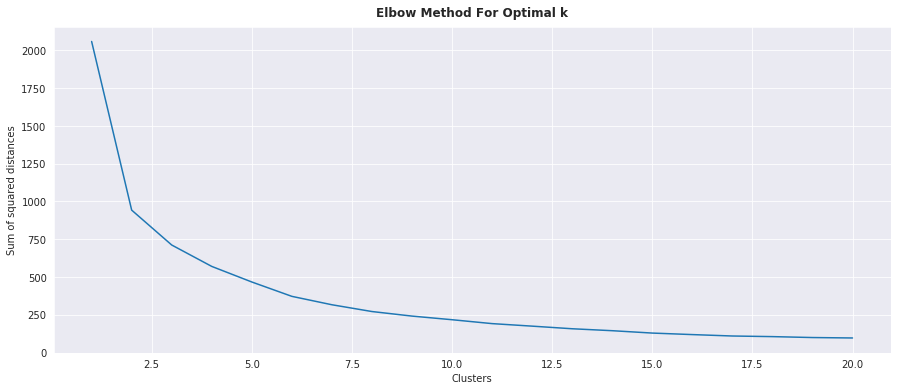

In [66]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Scaling features 
cols_to_scale = ['latitude_start', 'longitude_start']

# Initiate scaler algorithm, fit & transform scaled LAT & LON
scaler = MinMaxScaler()
scaled_latlon = scaler.fit_transform(df[cols_to_scale][:50000])

sum_of_squared_distances = []
clusters = [i for i in range(1, 21)] # Number of clusters to examinate

# Extract inertia score for each cluster
for k in clusters:
    km = KMeans(n_clusters = k)
    km = km.fit(scaled_latlon)
    sum_of_squared_distances.append(km.inertia_)

# Plot clusters Vs inertia scores
plt.figure(figsize = (15, 6))

_ = sns.lineplot(x = clusters, y = sum_of_squared_distances, markers = True)
_.set_title('Elbow Method For Optimal k', pad = 10, weight= 'bold')
_.set_xlabel('Clusters')
_.set_ylabel('Sum of squared distances')

plt.show()

- I believe best number of clusters will be 6 as it looks there's no major improvement in results.

In [73]:
# Temporary scale LAT & LON 
start_cols_to_scale = ['latitude_start', 'longitude_start']
end_cols_to_scale   = ['latitude_end', 'longitude_end']

start_scaled_latlon = scaler.transform(df[start_cols_to_scale])
end_scaled_latlon   = scaler.transform(df[end_cols_to_scale])

to_start_cols_to_scale = ['scaled_latitude_start', 'scaled_longitude_start']
to_end_cols_to_scale   = ['scaled_latitude_end', 'scaled_longitude_end']

df_start_scaled_latlon = pd.DataFrame(start_scaled_latlon, columns = to_start_cols_to_scale)
df_end_scaled_latlon   = pd.DataFrame(end_scaled_latlon, columns = to_end_cols_to_scale)

# Merge scaled LAT & LON with df - Temporary
df = df.merge(df_start_scaled_latlon, left_index = True, right_index = True)
df = df.merge(df_end_scaled_latlon, left_index = True, right_index = True)

# Initiate KMean algorithm with 6 clusters
km_6 = KMeans(n_clusters = 6, random_state = 42)
km_6.fit(df[['scaled_latitude_start', 'scaled_longitude_start']][:10000])

# Create new features for clusters
df['from_station_cluster'] = km_6.predict(df[['scaled_latitude_start', 'scaled_longitude_start']])
df['to_station_cluster']   = km_6.predict(df[['scaled_latitude_end', 'scaled_longitude_end']])

# Drop temporary scaled LAT & LON
df.drop(to_start_cols_to_scale + to_end_cols_to_scale, axis = 1, inplace = True)

# Plotting Functions Block

### Seaborn / Matlibplot Annotation

In [12]:
# Annotation function
def annotate_perct(ax_plot, total, add_height, rot):
    for p in ax_plot.patches:
        if np.isnan(p.get_height()):
            height = 0
            ax_plot.text(p.get_x() + p.get_width()/2., height, '', ha="center", va='center', fontsize=10, rotation = rot)  
        else:
            height = p.get_height()
            ax_plot.text(p.get_x() + p.get_width()/2., height + add_height, '{}  ( {}% )'.format(int(height), round((round(height / total, 3) * 100), 1)), ha="center", va='center', fontsize=10, rotation = rot)

### Seaborn Countplot - Single & Multiple Plots

In [68]:
# Annotation function
def annotate_perct(ax_plot, total, add_height, rot):
    for p in ax_plot.patches:
        if np.isnan(p.get_height()):
            height = 0
            ax_plot.text(p.get_x() + p.get_width()/2., height, '', ha="center", va='center', fontsize=10, rotation = rot)  
        else:
            height = p.get_height()
            ax_plot.text(p.get_x() + p.get_width()/2., height + add_height, '{}  ( {}% )'.format(int(height), round((round(height / total, 3) * 100), 1)), ha="center", va='center', fontsize=10, rotation = rot)
            
            
# Count plot function
def func_countplot_autoplot(ncols, plot_width, plot_length, x, order, height, total, rot, title, xlabel, ylabel, xrot, palette):   
    
    if ncols == 1:
        plt.figure(figsize = (plot_width, plot_length))
        
        _ = sns.countplot(x = x, order = order, palette = palette) 
        annotate_perct(ax_plot = _, add_height= height, total= total, rot= rot)
        
        _.set_title(title, pad = 10, weight= 'bold')
        _.set_xlabel(xlabel)
        _.set_xticklabels(_.get_xticklabels(), rotation = xrot)
        _.set_ylabel(ylabel)
        plt.show()
        
    elif ncols < 5:    
        fig, ax = plt.subplots(ncols = ncols, figsize= (plot_width, plot_length))
        
        for i in range(0, ncols):
            sns.countplot(x = x[i], order = order[i], palette = palette[i], ax = ax[i]) 
            annotate_perct(ax_plot = ax[i], add_height= height[i], total= total[i], rot= rot[i])
            ax[i].set_title(title[i], pad = 10, weight= 'bold')
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
            ax[i].set_ylabel(ylabel[i])
        plt.show()
        
    else:
        print('Error. You can not plot more than 4 graphs in 1 row.')
        
            
# Bar plot function
def func_barplot_autoplot(ncols, plot_width, plot_length, x, y, hue, order, height, total, rot, title, xlabel, ylabel, xrot, palette):
    
    if ncols == 1:
        plt.figure(figsize = (plot_width, plot_length))
        
        _ = sns.barplot(x = x, y = y, hue = hue, order = order, palette = palette) 
        annotate_perct(ax_plot = _, add_height= height, total= total, rot= rot)
        _.set_title(title, pad = 10, weight= 'bold')
        _.set_xlabel(xlabel)
        _.set_xticklabels(_.get_xticklabels(), rotation = xrot)
        _.set_ylabel(ylabel)
        plt.show()
    
    elif ncols < 5:
        fig, ax = plt.subplots(ncols = ncols, figsize= (plot_width, plot_length))

        for i in range(0, ncols): 
            sns.barplot(x = x[i], y = y[i], hue = hue[i], order = order[i], palette = palette[i], ax = ax[i]) 
            annotate_perct(ax_plot = ax[i], add_height= height[i], total= total[i], rot= rot[i])
            ax[i].set_title(title[i], pad = 10, weight= 'bold')
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
            ax[i].set_ylabel(ylabel[i])
        plt.show()
    
    else:
        print('Error. You can not plot more than 4 graphs in 1 row.')
        
    
# Scatter plot function    
def func_scatterplot_autoplot(ncols, plot_width, plot_length, x, y, title, xlabel, ylabel, xrot, palette):
    
    if ncols == 1:
        plt.figure(figsize = (plot_width, plot_length))
        _ = sns.scatterplot(x = x, y = y, palette = palette) 
        _.set_title(title, pad = 10, weight= 'bold')
        _.set_xlabel(xlabel)
        _.set_xticklabels(_.get_xticklabels(), rotation = xrot)
        _.set_ylabel(ylabel)
        plt.show()
    
    elif ncols < 5:
        fig, ax = plt.subplots(ncols = ncols, figsize= (plot_width, plot_length))
        for i in range(0, ncols):
            sns.scatterplot(x = x[i], y = y[i], palette = palette, ax = ax[i]) 
            ax[i].set_title(title[i], pad = 10, weight= 'bold')
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
            ax[i].set_ylabel(ylabel[i])
        plt.show()
    
    else:
        print('Error. You can not plot more than 4 graphs in 1 row.')

        
# Distribution / Histogram plot function            
def func_distplot_autoplot(ncols, plot_width, plot_length, x, title, xlabel, xrot, bins, rug, color):

    if ncols == 1:
        plt.figure(figsize = (plot_width, plot_length))
        _ = sns.distplot(x, color = color, bins = bins, rug = rug) 
        _.set_title(title, pad = 10, weight= 'bold')
        _.set_xlabel(xlabel)
        _.set_xticklabels(_.get_xticklabels(), rotation = xrot)
        plt.show()

    elif ncols < 5:
        fig, ax = plt.subplots(ncols = ncols, figsize= (plot_width, plot_length))
        for i in range(0, ncols):
            sns.distplot(x[i], color = color[i], bins = bins[i], rug = rug[i], ax = ax[i]) 
            ax[i].set_title(title[i], pad = 10, weight= 'bold')
            ax[i].set_xlabel(xlabel[i])
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = xrot[i])
        plt.show()
    
    else:
        print('Error. You can not plot more than 4 graphs in 1 row.')

# EDA Section

### Trip Duration Distribution

/home/haitham/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


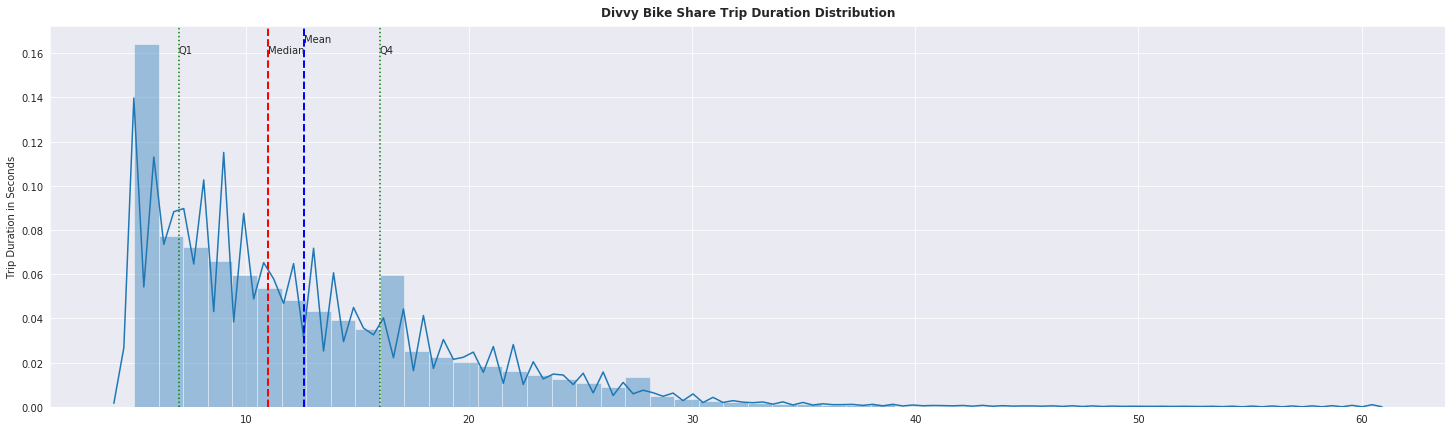

In [16]:
plt.figure(figsize= (25,7))

sns.distplot(df.new_tripduration.sort_values().values)

plt.axvline(df.new_tripduration.mean(), linestyle = '--', linewidth = 2, c = 'b')
plt.axvline(df.new_tripduration.median(), linestyle = '--', linewidth = 2, c = 'r')
plt.axvline(df.new_tripduration.quantile(0.25), linestyle = ':', c = 'g')
plt.axvline(df.new_tripduration.quantile(0.75), linestyle = ':', c = 'g')

plt.text(df.new_tripduration.mean(), 0.165, 'Mean', rotation = 0)
plt.text(df.new_tripduration.median(), 0.16, 'Median', rotation = 0)
plt.text(df.new_tripduration.quantile(0.25), 0.16, 'Q1', rotation = 0)
plt.text(df.new_tripduration.quantile(0.75), 0.16, 'Q4', rotation = 0)

plt.title('Divvy Bike Share Trip Duration Distribution', pad = 10, weight = 'bold')
plt.ylabel('Trip Duration in Seconds')

plt.show()

### Visualize Categorical Features
- **Customers**: 'usertype', 'gender'
- **Stations** : 'from_station_name', 'to_station_name'
- **Weather**  :'events', 'rain', 'conditions', 'wind_bins'
- **Date**     :'year', 'month', 'weekday', and daily trips
- **Variables Correlation** : ['new_tripduration', 'temperature', 'humidity', 'wind_speed', 'distance']

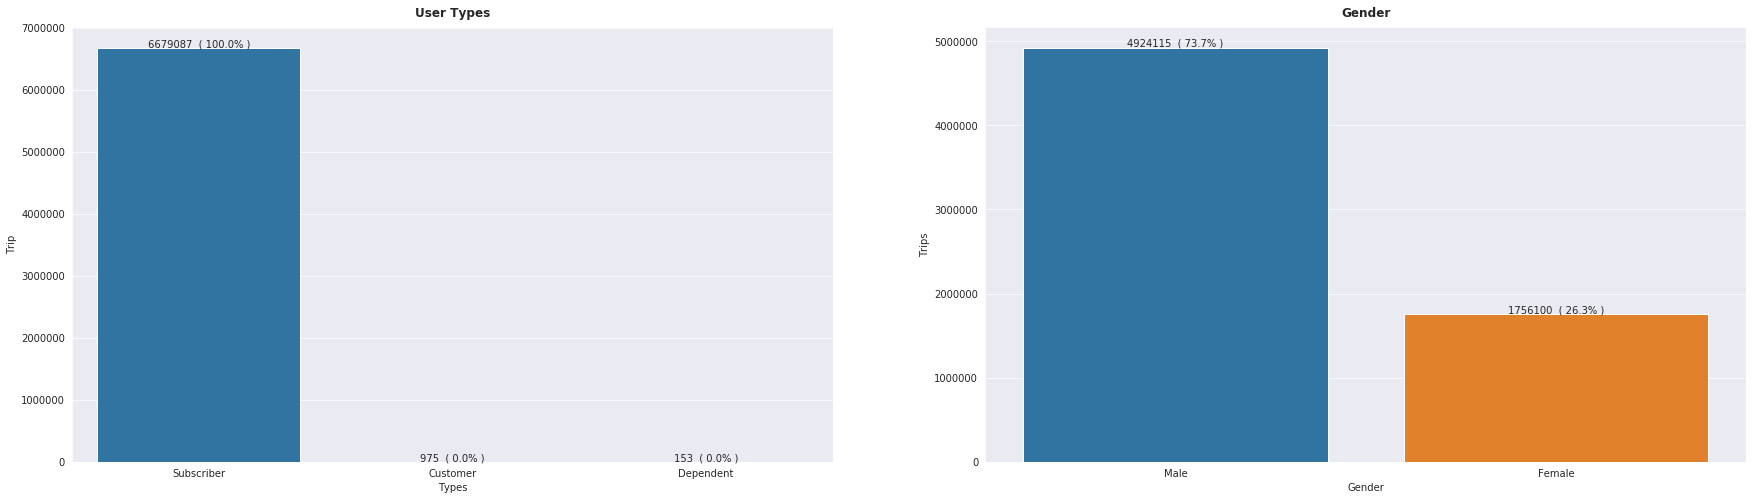

In [17]:
rep_users  = {0: 'Subscriber', 1: 'Customer', 3: 'Dependent'}
rep_gender = {0: 'Male', 1: 'Female'}

order_users  = ['Subscriber', 'Customer', 'Dependent']
order_gender = ['Male', 'Female']

func_countplot_twoplot( x       = [df.usertype.replace(rep_users), df.gender.replace(rep_gender)],
                        order   = [order_users, order_gender], 
                        height  = [50000, 50000], 
                        total   = [len(df), len(df)], 
                        rot     = [0,0], 
                        title   = ['User Types', 'Gender'], 
                        xlabel  = ['Types', 'Gender'], 
                        ylabel  = ['Trip', 'Trips'],
                        xrot    = [None, None],
                        palette = [None, None] )

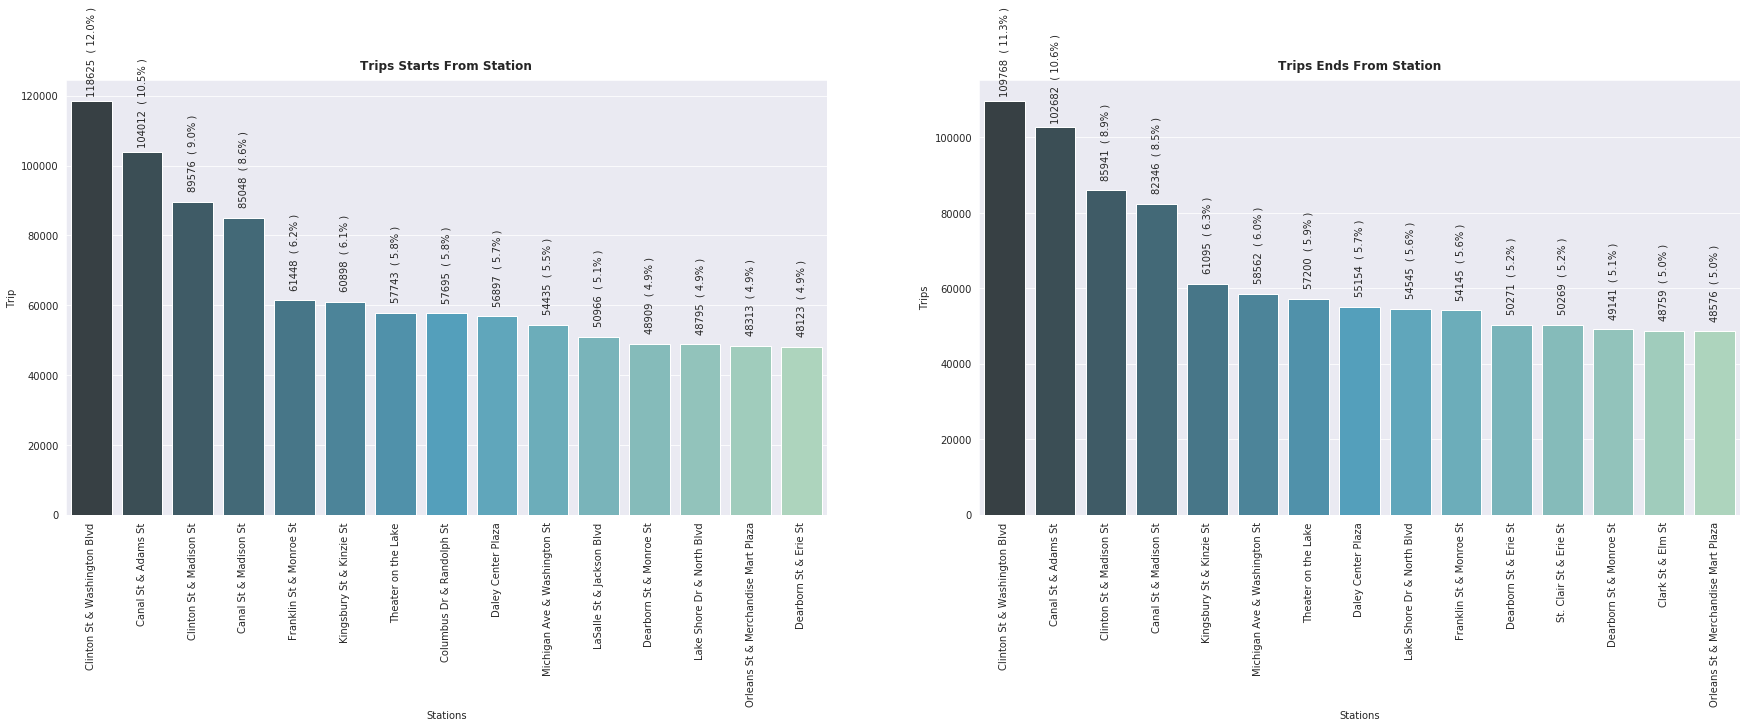

In [18]:
# Since it's difficult to visualize all stations ( total of 640 unique stations ). I decided to plot the to 15 stations based on trips

from_station     = df.from_station_name.value_counts().keys().tolist()[:15]
from_station_sum = sum(df.from_station_name.value_counts().values.tolist()[:15])
to_station       = df.to_station_name.value_counts().keys().tolist()[:15]
to_station_sum   = sum(df.to_station_name.value_counts().values.tolist()[:15])

func_countplot_twoplot( x       = [df.loc[df.from_station_name.isin(from_station), 'from_station_name'], df.loc[df.to_station_name.isin(to_station), 'to_station_name']],
                        order   = [from_station, to_station], 
                        height  = [14000, 13000], 
                        total   = [from_station_sum, to_station_sum], 
                        rot     = [90, 90], 
                        title   = ['Trips Starts From Station', 'Trips Ends From Station'], 
                        xlabel  = ['Stations', 'Stations'], 
                        ylabel  = ['Trip', 'Trips'],
                        xrot    = [90, 90],
                        palette = ['GnBu_d', 'GnBu_d'])

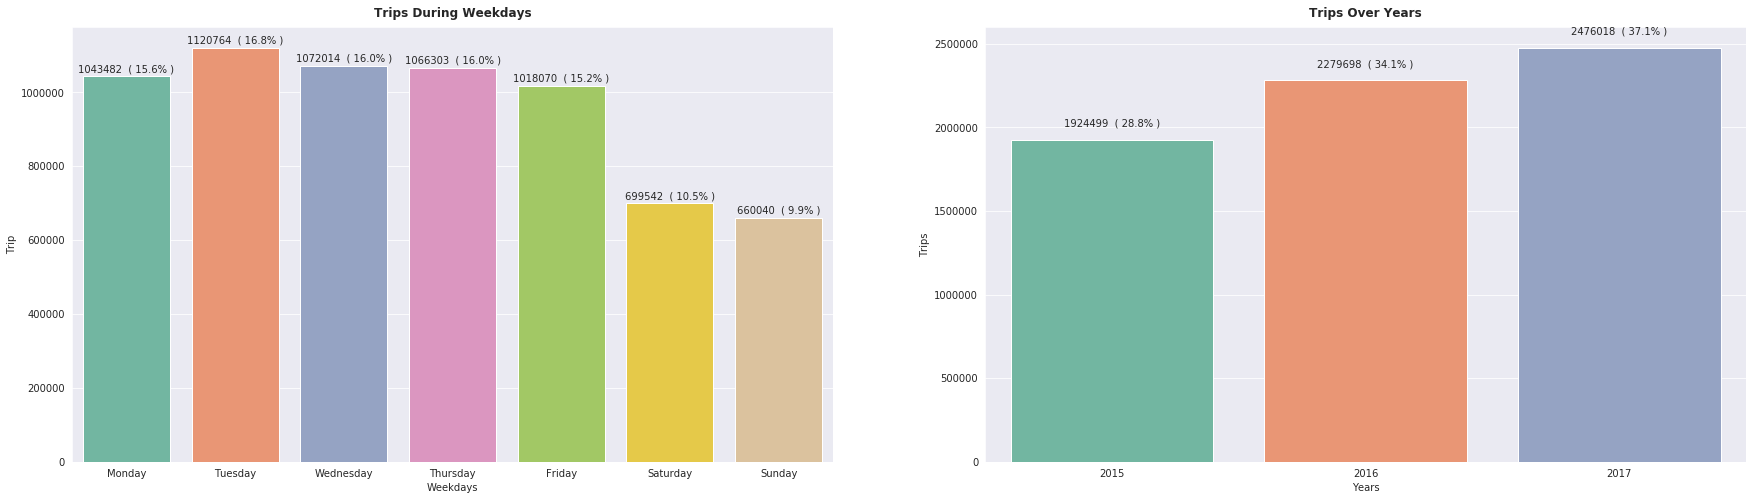

In [19]:
rep_weekdays  = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

func_countplot_twoplot( x       = [df.weekday.replace(rep_weekdays), df.year],
                        order   = [weekday_order, [2015, 2016, 2017]],
                        height  = [20000, 100000], 
                        total   = [len(df), len(df)], 
                        rot     = [None, None], 
                        title   = ['Trips During Weekdays', 'Trips Over Years'], 
                        xlabel  = ['Weekdays', 'Years'], 
                        ylabel  = ['Trip', 'Trips'],
                        xrot    = [None, None],
                        palette = ['Set2', 'Set2'])

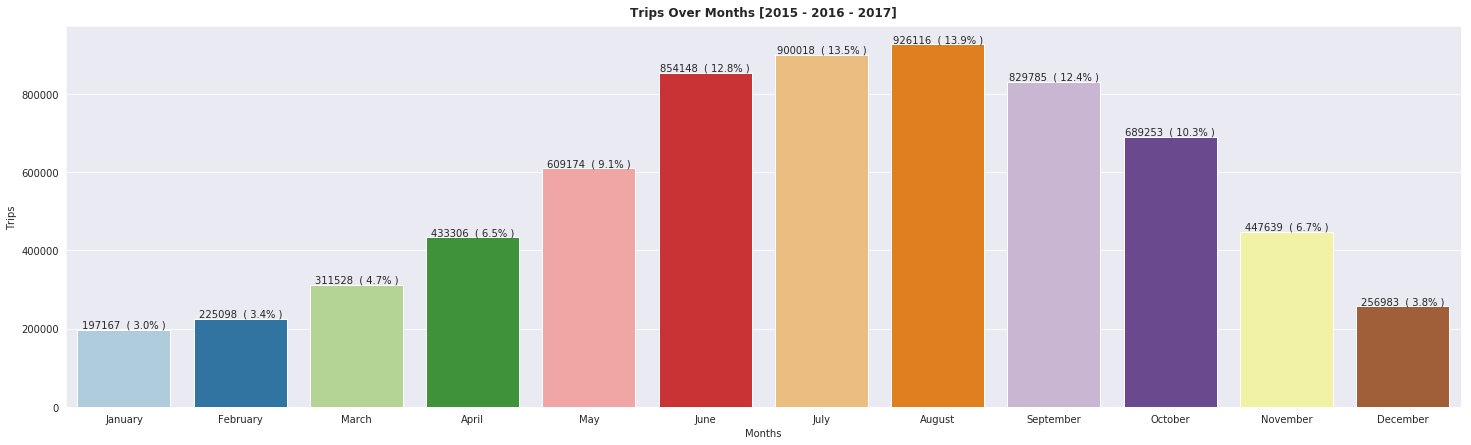

In [22]:
rep_months   = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

func_countplot_oneplot( x       = df.month.replace(rep_months),
                        order   = months_order,
                        height  = 13000,
                        total   = len(df),
                        rot     = 0,
                        title   = 'Trips Over Months [2015 - 2016 - 2017]',
                        xlabel  = 'Months',
                        xrot    = None,
                        ylabel  = 'Trips',
                        palette = 'Paired')

In [23]:
rep_rain     = {0: 'No Rain', 1: 'Rain'}
rain_order   = ['No Rain', 'Rain']

events_order = df.events.value_counts().keys().tolist()

func_countplot_twoplot( x       = [df.rain.replace(rep_rain), df.events],
                        order   = [rain_order, events_order],
                        height  = [100000, 280000], 
                        total   = [len(df), len(df)], 
                        rot     = [None, 75], 
                        title   = ['Trips During Rainy Days', 'Trips During Weather Events'], 
                        xlabel  = ['Rainy Days', 'Weather Events'], 
                        ylabel  = ['Trip', 'Trips'],
                        xrot    = [None, None],
                        palette = [None, 'Set2'])

In [24]:
conditions_order = df.conditions.value_counts().keys().tolist()

func_countplot_oneplot( x       = df.conditions,
                        order   = conditions_order,
                        height  = 270000,
                        total   = len(df),
                        rot     = 75,
                        title   = 'Trips During Weather Conditions',
                        xlabel  = 'Weather Conditions',
                        xrot    = 90,
                        ylabel  = 'Trips',
                        palette = 'Paired')

In [97]:
wind_order = df.wind_bins.value_counts().keys().tolist()

func_countplot_oneplot( x       = df.wind_bins,
                        order   = wind_order,
                        height  = 50000,
                        total   = len(df),
                        rot     = 0,
                        title   = 'Trips During Windy Weather',
                        xlabel  = 'Weather',
                        xrot    = 0,
                        ylabel  = 'Trips',
                        palette = 'Paired')

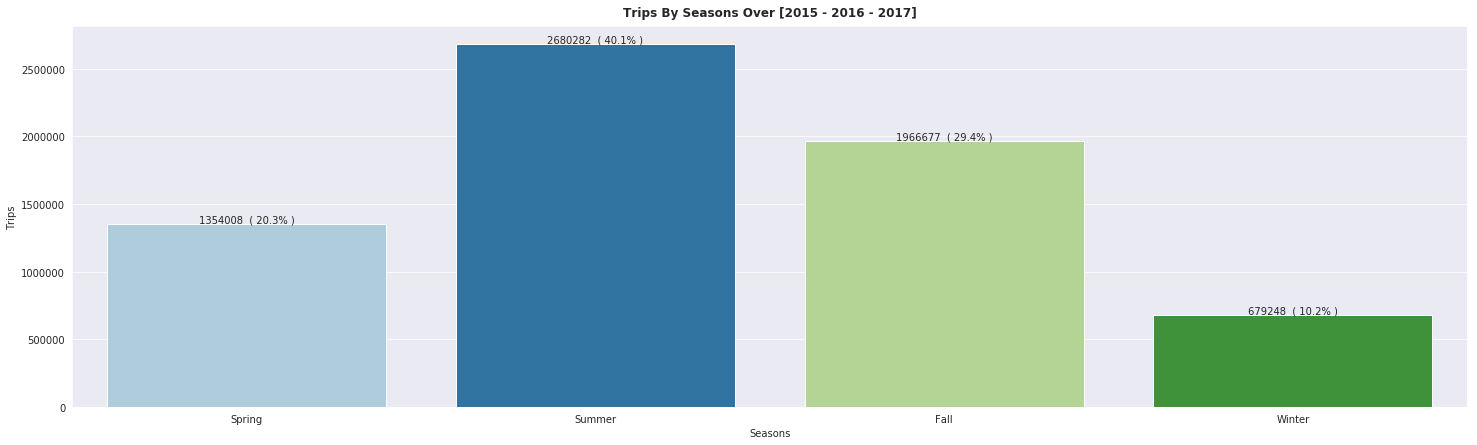

In [104]:
rep_seasons   = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
seasons_order = ['Spring', 'Summer', 'Fall', 'Winter']

func_countplot_oneplot( x       = df.seasons.replace(rep_seasons),
                        order   = seasons_order,
                        height  = 32000,
                        total   = len(df),
                        rot     = 0,
                        title   = 'Trips By Seasons Over [2015 - 2016 - 2017]',
                        xlabel  = 'Seasons',
                        xrot    = None,
                        ylabel  = 'Trips',
                        palette = 'Paired')


In [33]:
# 'spearman' non parametric distributed variables 
spearman_corr_df = df[['new_tripduration', 'temperature', 'humidity', 'wind_speed', 'distance_station', 'distance_trip']].corr(method = 'spearman')

# Plot variables correlation
plt.figure(figsize = (8,6))

_ = sns.heatmap(spearman_corr_df, annot= True, fmt = '.2f', cmap= 'YlGnBu')
_.set_title('Correlation Heatmap', pad = 10, weight = 'bold')

plt.show()

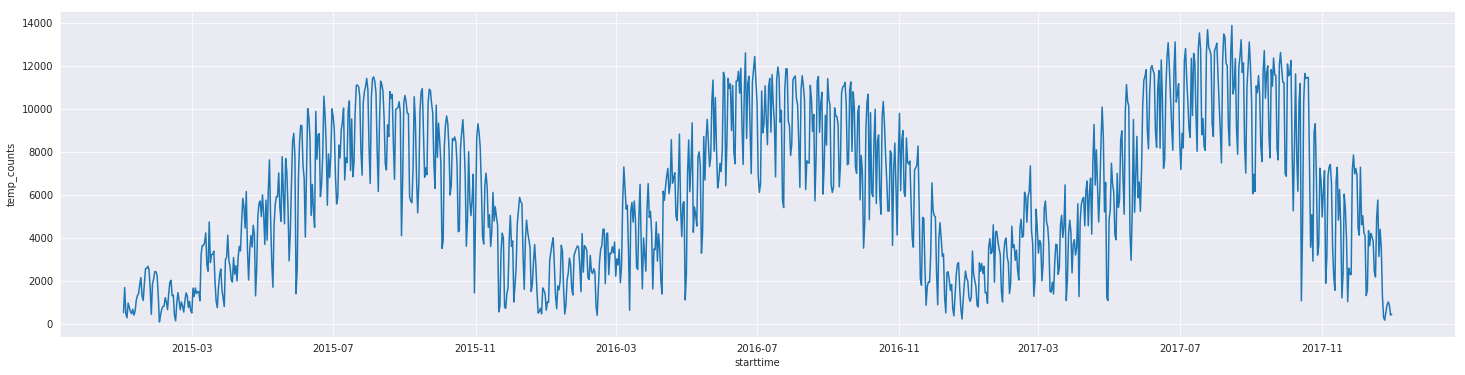

In [78]:
# Create df['temp_counts'] temporary
df['temp_counts'] = 1

sampled_df = df[['starttime', 'temp_counts']]
sampled_df = sampled_df.set_index('starttime').resample('D').sum()

plt.figure(figsize = (25,6))

_ = sns.lineplot(data = sampled_df, x = sampled_df.index, y = sampled_df.temp_counts)

_.set_title('', pad = 10, weight= 'bold')
_.set_xlabel('')
_.set_xticklabels(_.get_xticklabels(), rotation = 90)
_.set_ylabel('')

plt.show()

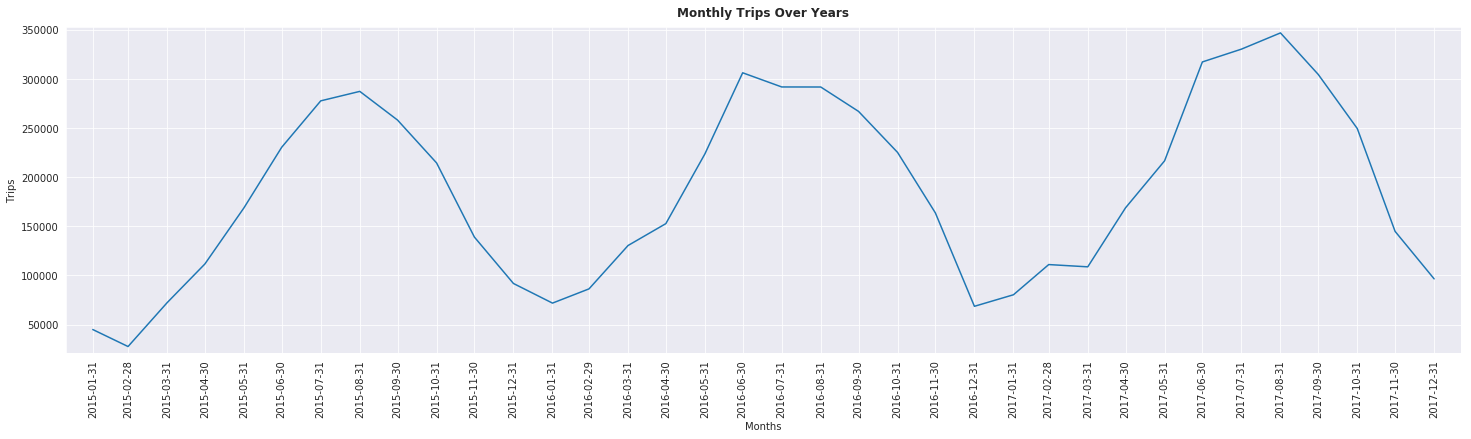

In [156]:
sampled_df = df[['starttime', 'temp_counts']]
sampled_df = sampled_df.set_index('starttime').resample('M').sum()
temp_x     = sampled_df.index.astype('str').tolist()

plt.figure(figsize = (25,6))

_ = sns.lineplot(data = sampled_df, x = sampled_df.index, y = sampled_df.temp_counts)

_.set_title('Monthly Trips Over Years', pad = 10, weight= 'bold')
_.set_xlabel('Months')
_.set_xticks(temp_x)
_.set_xticklabels(temp_x, rotation = 90)
_.set_ylabel('Trips')
_.margins(0.02)

plt.show()

In [158]:
plt.figure(figsize = (25,8))

_ = sns.barplot(data = sampled_df, x = sampled_df.index, y = sampled_df.temp_counts, palette = 'Paired')
annotate_perct(ax_plot = _, add_height = 40000, total = sampled_df.temp_counts.sum(), rot= 90)

_.set_title('Monthly Trips Over Years', pad = 40, weight= 'bold')
_.set_xlabel('Months')
_.set_xticklabels(temp_x, rotation = 90)
_.set_ylabel('Trips')
_.margins(0.02)

plt.show()

In [179]:
data = [go.Bar(x = temp_x, y = sampled_df.temp_counts.tolist())]
iplot(data)

### Geographical Visualization

In [30]:
# Trips count
from_stations_group = df.groupby(['from_station_name', 'latitude_start', 'longitude_start']).size().reset_index().rename(columns={0: 'trips_count'})
to_stations_group   = df.groupby(['to_station_name', 'latitude_end', 'longitude_end']).size().reset_index().rename(columns={0: 'trips_count'})

# Trips duration
stations_duration_group = df.groupby(['from_station_name', 'latitude_start', 'longitude_start']).agg({'new_tripduration': 'sum'})\
                                                                                                .reset_index()\
                                                                                                .rename(columns = {'from_station_name': 'station', 'new_tripduration': 'sumduration'})

# Convert the pickup LAT & LON to array to plot points on map  
coordinates_arr    = np.array(from_stations_group[['latitude_start', 'longitude_start']])
coordinates_arr_to = np.array(to_stations_group[['latitude_end', 'longitude_end']])
coordinates_arr_full    = np.array(from_stations_group[['latitude_start', 'longitude_start', 'trips_count']])
coordinates_arr_full_duration = np.array(stations_duration_group[['latitude_start', 'longitude_start', 'sumduration']])

In [2]:
def chicago_map():
    return folium.Map(location = [41.8781, -87.6298], zoom_start = 11, control_scale = True, tiles ='Cartodb dark_matter')

In [4]:
chicago_map()

In [82]:
# Best views are: 'Stamen Terrain', 'Stamen Toner', 'Cartodb Positron'
stations_map = chicago_map()

for i in range(0, len(coordinates_arr)):
    folium.CircleMarker(coordinates_arr[i]   , radius = 1, fill = True, opacity = 0.7, color = 'yellow').add_to(stations_map)

stations_map

In [15]:
stations_map = chicago_map()

plugins.HeatMap(data = coordinates_arr_full, radius = 8, max_zoom = 50).add_to(stations_map)
stations_map

In [34]:
stations_map = chicago_map()

plugins.HeatMap(data = coordinates_arr_full_duration, radius = 8, max_zoom = 50).add_to(stations_map)
stations_map

In [16]:
stations_map = chicago_map()

for i in range(0, len(coordinates_arr)):
    folium.CircleMarker(coordinates_arr[i], radius = 0.6, fill = True, opacity = 0.7, color = 'red').add_to(stations_map)

plugins.HeatMap(data = coordinates_arr_full, radius = 8, max_zoom = 10).add_to(stations_map)
stations_map

In [48]:
#from_stations_group = df.groupby(['from_station_name', 'latitude_start', 'longitude_start']).size().reset_index().rename(columns={0: 'trips_count'})
from_stations_group['combination'] = from_stations_group.from_station_name.astype('str') + ' | Total Trips: ' +from_stations_group.trips_count.astype('str')

test_coordinates_arr          = from_stations_group[['latitude_start', 'longitude_start']].values
test_coordinates_arr_counts   = from_stations_group.trips_count.values
test_coordinates_arr_names    = from_stations_group.from_station_name.values
test_coordinates_arr_combined = from_stations_group.combination.values

In [50]:
# Convert the pickup LAT & LON to array to plot points on map  
stations_map = chicago_map()

plugins.MarkerCluster(locations = test_coordinates_arr, popups = test_coordinates_arr_combined).add_to(stations_map)
stations_map

In [51]:
# Convert the pickup LAT & LON to array to plot points on map  
stations_map = chicago_map()

plugins.MarkerCluster(locations = test_coordinates_arr, popups = test_coordinates_arr_combined).add_to(stations_map)
plugins.Fullscreen(position='topright', title='Full Map', title_cancel='Exit', force_separate_button=True).add_to(stations_map)

stations_map


### Distance, Temperature and Wind Speed Scatter Plot

In [34]:
plt.figure(figsize = (25,7))

sns.scatterplot(data = df, x = 'new_tripduration', y = 'distance_trip', hue = 'usertype', palette="Set2")

plt.show()

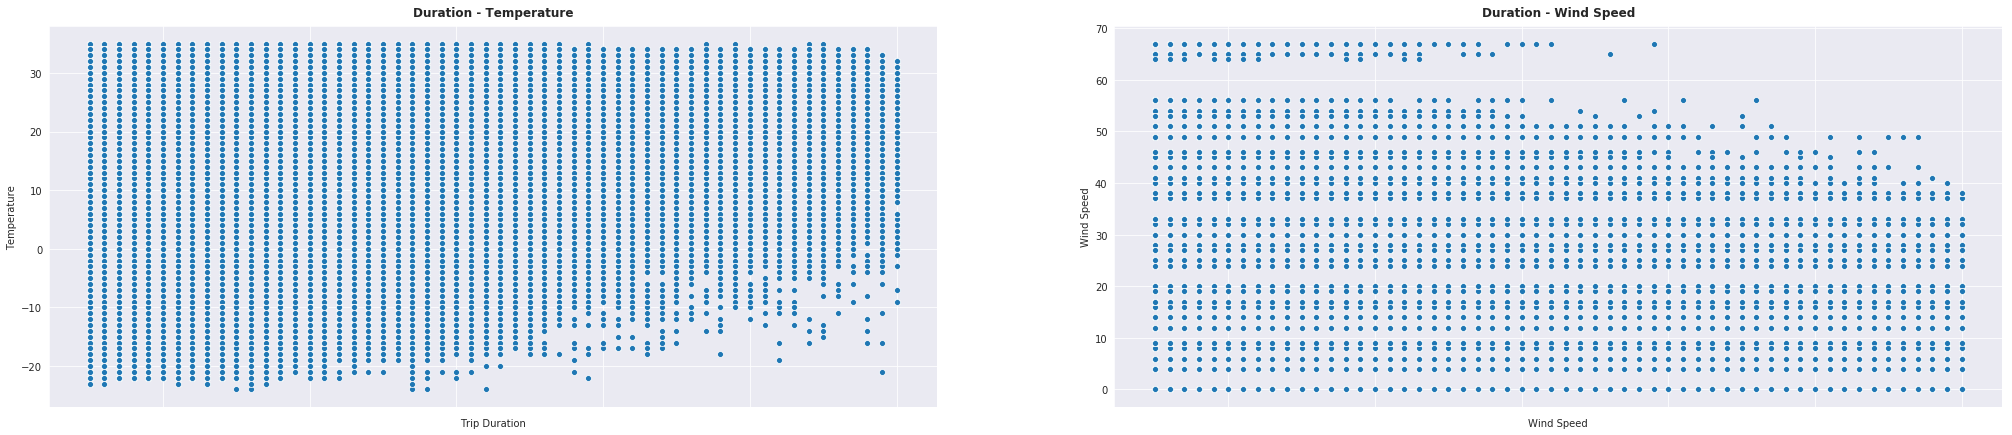

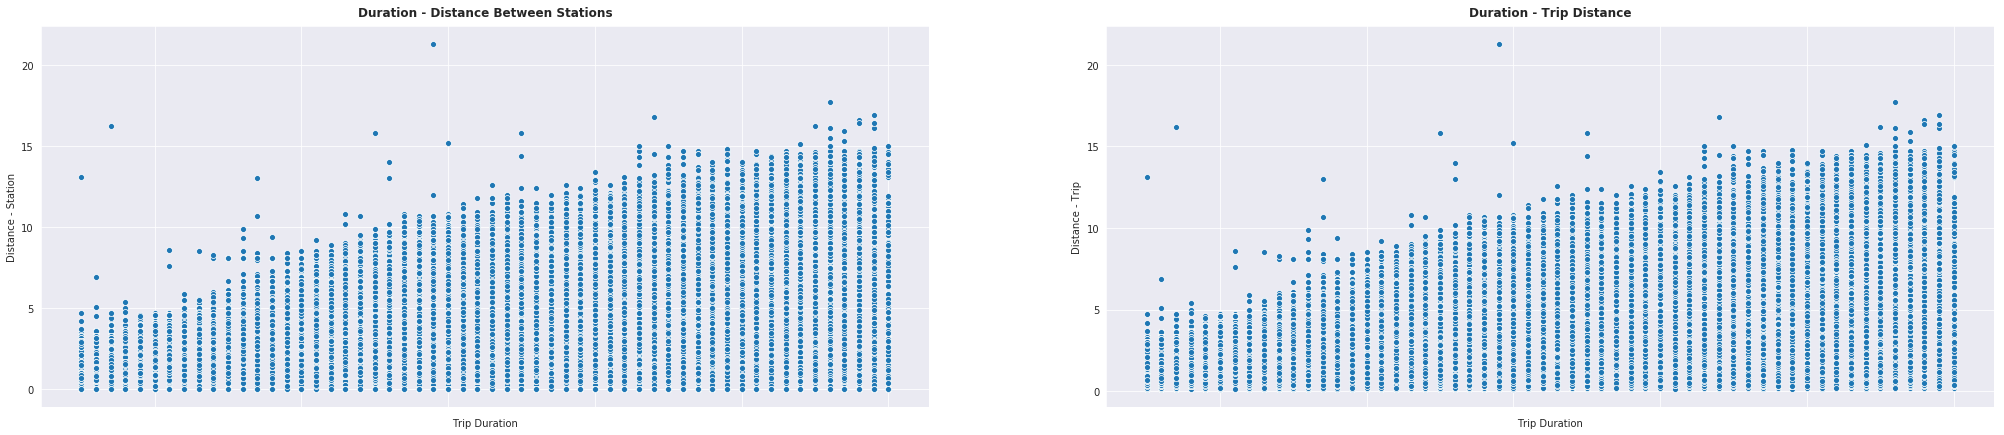

In [37]:
func_scatterplot_twoplot( x       = [df.new_tripduration, df.new_tripduration], 
                          y       = [df.temperature, df.wind_speed], 
                          title   = ['Duration - Temperature', 'Duration - Wind Speed'], 
                          xlabel  = ['Trip Duration', 'Wind Speed'], 
                          ylabel  = ['Temperature', 'Wind Speed'], 
                          xrot    = [0, 0], 
                          palette = ['Blues_d', 'Blues_d'] )

func_scatterplot_twoplot( x       = [df.new_tripduration, df.new_tripduration], 
                          y       = [df.distance_station, df.distance_trip], 
                          title   = ['Duration - Distance Between Stations', 'Duration - Trip Distance'], 
                          xlabel  = ['Trip Duration', 'Trip Duration'], 
                          ylabel  = ['Distance - Station', 'Distance - Trip'], 
                          xrot    = [0, 0], 
                          palette = ['Blues_d', 'Blues_d'] )

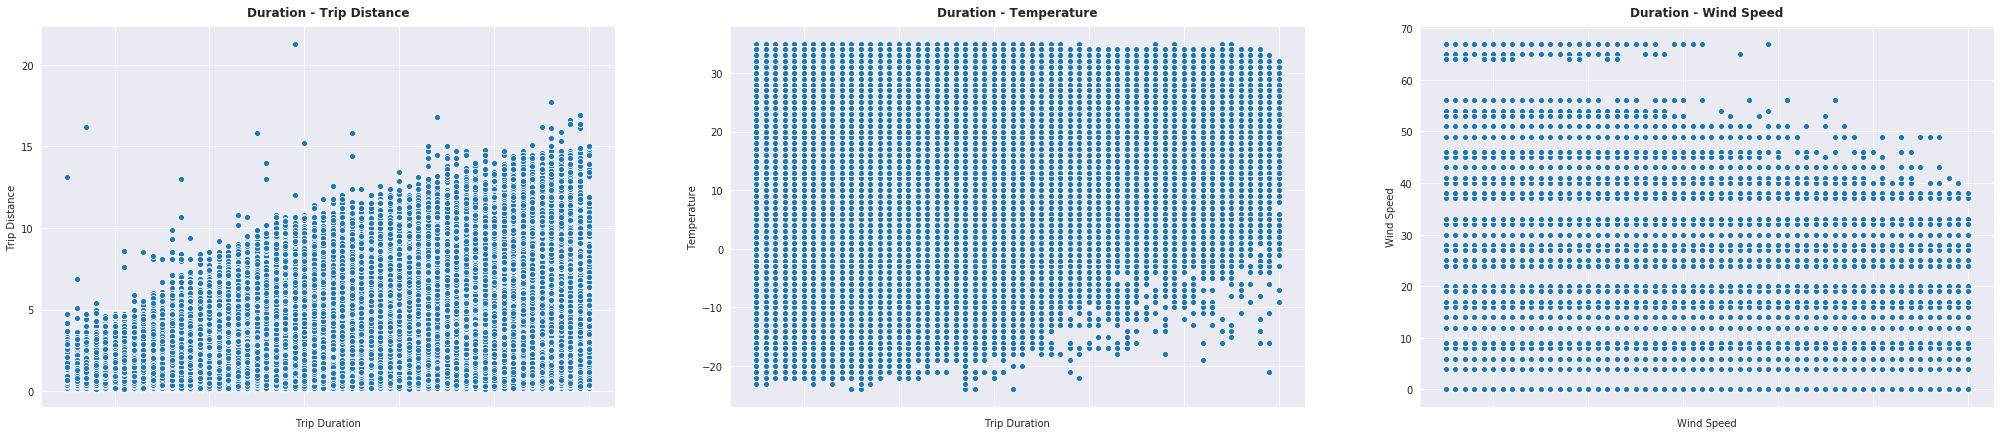

In [12]:
func_scatterplot_threeplot( x       = [df.new_tripduration, df.new_tripduration, df.new_tripduration], 
                            y       = [df.distance_trip, df.temperature, df.wind_speed], 
                            title   = ['Duration - Trip Distance', 'Duration - Temperature', 'Duration - Wind Speed'], 
                            xlabel  = ['Trip Duration', 'Trip Duration', 'Wind Speed'], 
                            ylabel  = ['Trip Distance', 'Temperature', 'Wind Speed'], 
                            xrot    = [0, 0, 0], 
                            palette = ['Blues_d', 'Blues_d', 'Blues_d'] )

### Distance, Temperature and Wind Speed Distribution

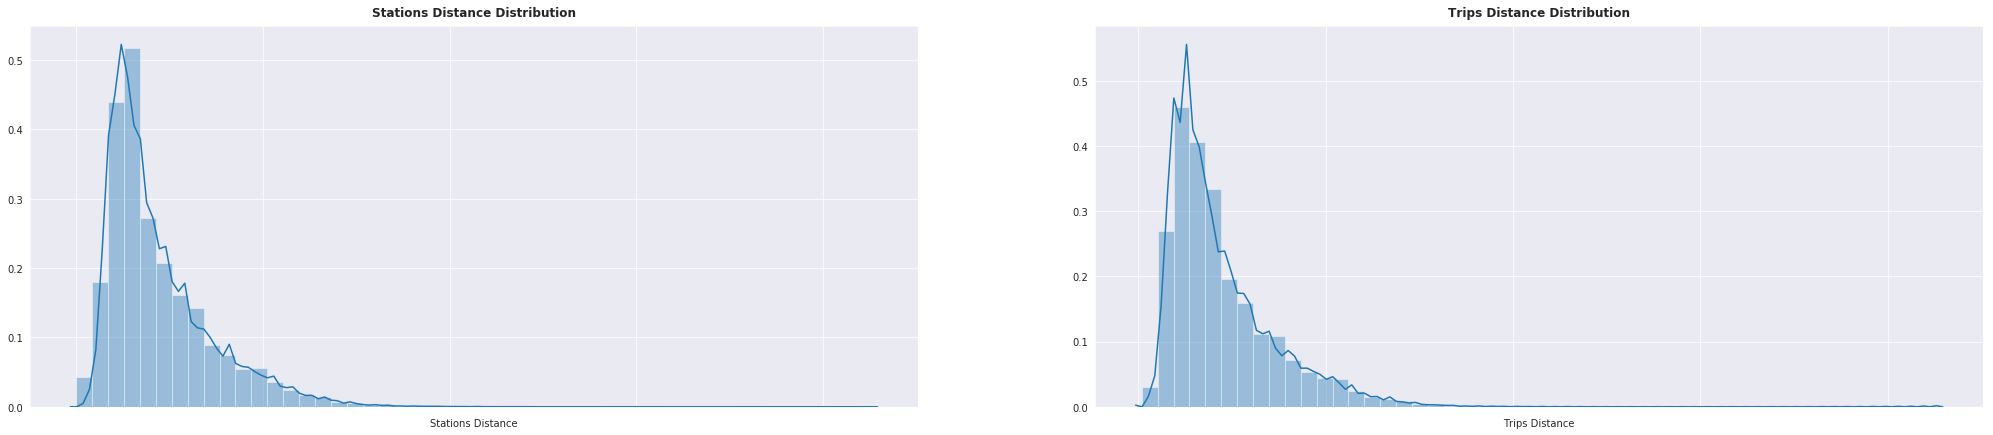

In [16]:
func_distplot_twoplot( x      = [df.distance_station, df.distance_trip], 
                       title  = ['Stations Distance Distribution', 'Trips Distance Distribution'],
                       xlabel = ['Stations Distance', 'Trips Distance'], 
                       xrot   = [0, 0], 
                       rug    = [False, False],
                       bins   = [None, None], 
                       color  = [None, None])

In [17]:
func_distplot_twoplot( x      = [df.temperature, df.wind_speed], 
                       title  = ['Temperature Distribution', 'Wind Speed Distribution'],
                       xlabel = ['Temperature', 'Wind Speed'], 
                       xrot   = [0, 0], 
                       rug    = [False, False],
                       bins   = [None, None], 
                       color  = [None, None])

### Weekdays Average Trip Duration

In [25]:
weekdays_mean_tripduration = df.groupby('weekday').agg({'new_tripduration': lambda x: round(x.mean(),2),\
                                                        'distance_trip': lambda x: round(x.mean(),2)})\
                                                  .reset_index()\
                                                  .rename(columns = {'new_tripduration': 'mean_tripduration', 
                                                                     'distance_trip': 'mean_tripdistance'})

weekdays_mean_tripduration.weekday = weekdays_mean_tripduration.weekday.replace(rep_weekdays)

# Create trace data 
trace0 = go.Bar(x = weekdays_mean_tripduration.weekday, 
                y = weekdays_mean_tripduration.mean_tripduration, 
                name   = 'Avg. Duration',
                marker = dict(color = ['#BBBBBB', '#BBBBBB', '#BBBBBB', '#BBBBBB', '#BBBBBB', '#0eba0e', '#0b8e0b']))

trace1 = go.Scatter(x = weekdays_mean_tripduration.weekday, 
                    y = weekdays_mean_tripduration.mean_tripdistance, 
                    mode   ='lines+markers', 
                    name   = 'Avg. Distance',
                    marker = dict(size = weekdays_mean_tripduration.mean_tripdistance * 10))

# Create layout customization
layout = go.Layout(title = 'Average Trip Duration by Weekdays', 
                   xaxis = dict(title = 'Weekdays', titlefont = dict(size = 12, color = '#7f7f7f')),
                   yaxis = dict(title = 'Average Trip Duration', titlefont = dict(size = 12, color = '#7f7f7f')))

data = [trace0, trace1]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

### Monthly Average Trip Duration

In [27]:
monthly_mean_tripduration = df.groupby('month').agg({'new_tripduration': lambda x: round(x.mean(),2),\
                                                     'distance_trip': lambda x: round(x.mean(),2)})\
                                               .reset_index()\
                                               .rename(columns = {'new_tripduration': 'mean_tripduration', 
                                                                  'distance_trip': 'mean_tripdistance'})

monthly_mean_tripduration.month = monthly_mean_tripduration.month.replace(rep_months)

# Figure #1
# Create trace data 
trace0 = go.Bar(x = monthly_mean_tripduration.month, 
                y = monthly_mean_tripduration.mean_tripduration, 
                name   = 'Avg. Duration',
                marker = dict(color = ['#BBBBBB','#BBBBBB','#BBBBBB','#BBBBBB','#BBBBBB','#0eba0e','#0eba0e','#0eba0e','#BBBBBB','#BBBBBB','#BBBBBB','#BBBBBB']))

trace1 = go.Scatter(x = monthly_mean_tripduration.month, 
                    y = monthly_mean_tripduration.mean_tripdistance, 
                    mode   = 'lines+markers', 
                    name   = 'Avg. Distance',
                    marker = dict(size = monthly_mean_tripduration.mean_tripdistance * 10))


# Create layout customization
layout = go.Layout(title = 'Average Trip Duration by Month', 
                   xaxis = dict(title = 'Month', titlefont = dict(size = 12, color = '#7f7f7f')),
                   yaxis = dict(title = 'Average Trip Duration', titlefont = dict(size = 12, color = '#7f7f7f')))

data = [trace0, trace1]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [1]:
rep_holidays  = {True: 'Holiday', False: 'Regular Day'}
holiday_order = ['Holiday', 'Regular Day']

rep_weekends   = {True: 'Weekend', False: 'Weekday'}
weekends_order = ['Weekend', 'Weekday']

func_countplot_autoplot(ncols       = 2,
                        plot_width  = 35,
                        plot_length = 8, 
                        x       = [df.is_holiday.replace(rep_holidays), df.is_weekends.replace(rep_weekends)],
                        order   = [holiday_order, weekends_order],
                        height  = [100000, 100000], 
                        total   = [len(df), len(df)], 
                        rot     = [None, None], 
                        title   = ['Trips During Holidays', 'Trips During Weekends'], 
                        xlabel  = ['Holidays Vs Regular Days', 'Weekends Vs Weekdays'], 
                        ylabel  = ['Trip', 'Trips'],
                        xrot    = [None, None],
                        palette = [None, None])

NameError: name 'func_countplot_autoplot' is not defined

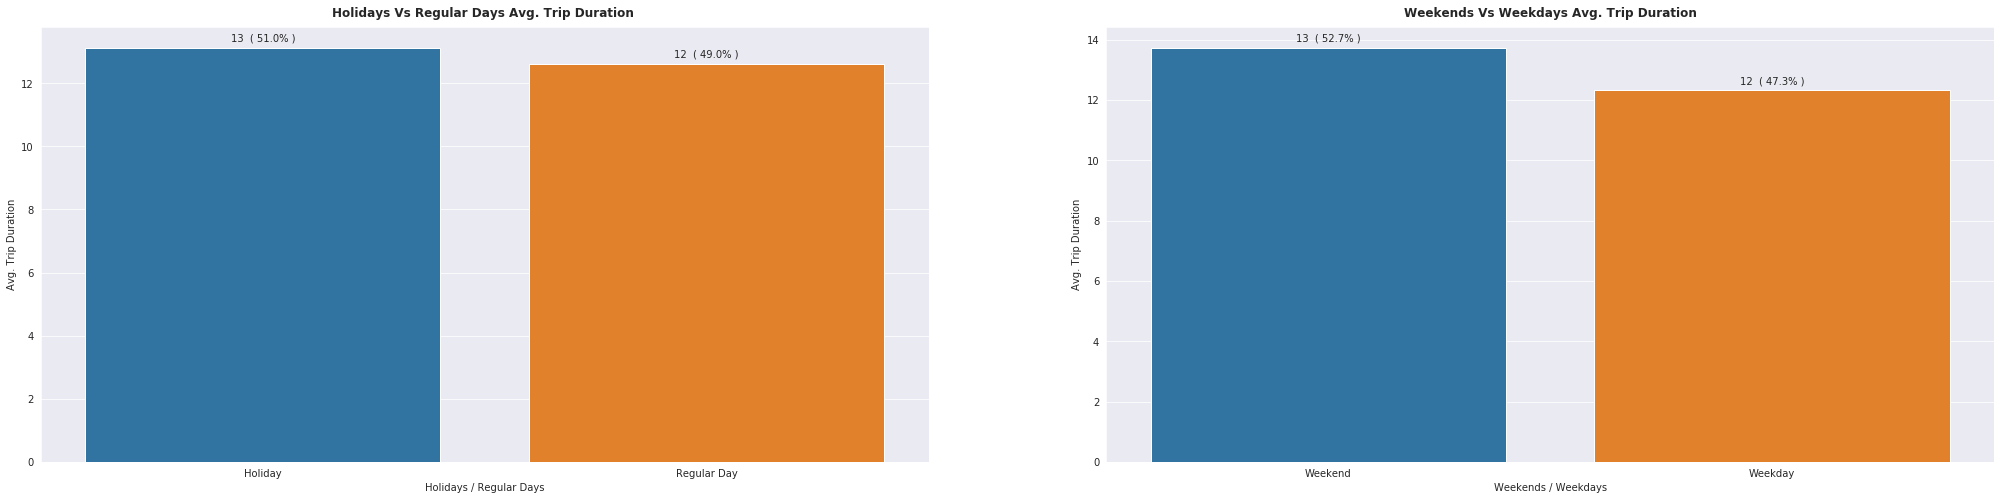

In [94]:
# Test 
func_barplot_autoplot( ncols       = 2,
                       plot_width  = 35,
                       plot_length = 8, 
                       x       = [grouped_holidays.is_holiday, grouped_weekends.is_weekends],
                       y       = [grouped_holidays.mean_tripduration, grouped_weekends.mean_tripduration],
                       hue     = [None, None],
                       order   = [holiday_order, weekends_order],
                       height  = [0.3, 0.3], 
                       total   = [grouped_holidays.mean_tripduration.sum(), grouped_weekends.mean_tripduration.sum()], 
                       rot     = [None, None], 
                       title   = ['Holidays Vs Regular Days Avg. Trip Duration ', 'Weekends Vs Weekdays Avg. Trip Duration'], 
                       xlabel  = ['Holidays / Regular Days', 'Weekends / Weekdays'], 
                       ylabel  = ['Avg. Trip Duration', 'Avg. Trip Duration'],
                       xrot    = [None, None],
                       palette = [None, None])

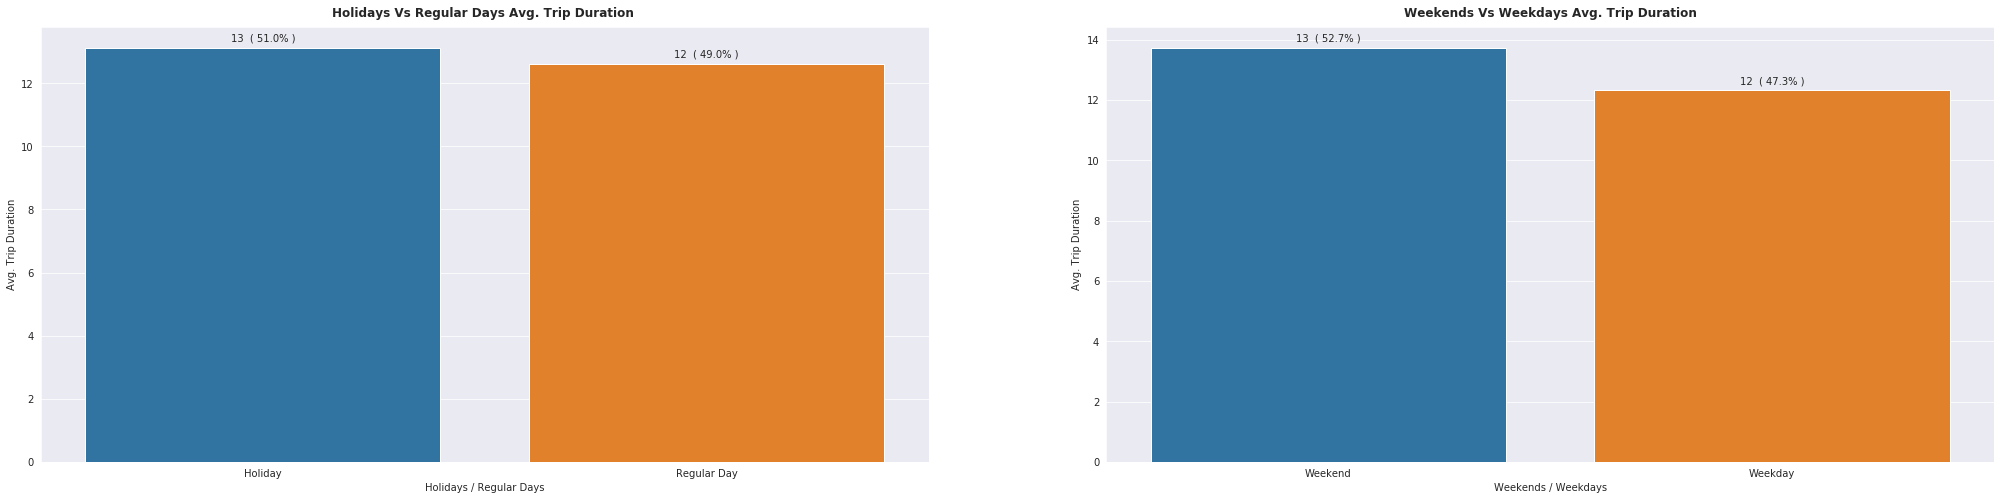

In [13]:
# Aggregate required data for holidays and weekends based on average trip duration 
grouped_holidays = df.groupby('is_holiday').agg({'new_tripduration': lambda x: round(x.mean(),2), 'distance_trip': lambda x: round(x.mean(),2)})\
                                           .reset_index().rename(columns = {'new_tripduration': 'mean_tripduration', 'distance_trip': 'mean_tripdistance'})\
                                           .replace(rep_holidays)

grouped_weekends = df.groupby('is_weekends').agg({'new_tripduration': lambda x: round(x.mean(),2), 'distance_trip': lambda x: round(x.mean(),2)})\
                                            .reset_index().rename(columns = {'new_tripduration': 'mean_tripduration', 'distance_trip': 'mean_tripdistance'})\
                                            .replace(rep_weekends)

# Reorder the xaxis
holiday_order = ['Holiday', 'Regular Day']
weekends_order = ['Weekend', 'Weekday']

# Holidays & weekends average duration plot 
func_barplot_autoplot(ncols       = 2,
                      plot_width  = 35,
                      plot_length = 8,
                      x       = [grouped_holidays.is_holiday, grouped_weekends.is_weekends],
                      y       = [grouped_holidays.mean_tripduration, grouped_weekends.mean_tripduration],
                      hue     = [None, None],
                      order   = [holiday_order, weekends_order],
                      height  = [0.3, 0.3], 
                      total   = [grouped_holidays.mean_tripduration.sum(), grouped_weekends.mean_tripduration.sum()], 
                      rot     = [None, None], 
                      title   = ['Holidays Vs Regular Days Avg. Trip Duration ', 'Weekends Vs Weekdays Avg. Trip Duration'], 
                      xlabel  = ['Holidays / Regular Days', 'Weekends / Weekdays'], 
                      ylabel  = ['Avg. Trip Duration', 'Avg. Trip Duration'],
                      xrot    = [None, None],
                      palette = [None, None])

# Holidays & weekends average distance plot
func_barplot_autoplot(ncols       = 2,
                      plot_width  = 35,
                      plot_length = 8,
                      x       = [grouped_holidays.is_holiday, grouped_weekends.is_weekends],
                      y       = [grouped_holidays.mean_tripdistance, grouped_weekends.mean_tripdistance],
                      hue     = [None, None],
                      order   = [holiday_order, weekends_order],
                      height  = [0.05, 0.05], 
                      total   = [grouped_holidays.mean_tripdistance.sum(), grouped_weekends.mean_tripdistance.sum()], 
                      rot     = [None, None], 
                      title   = ['Holidays Vs Regular Days Avg. Trip Distance ', 'Weekends Vs Weekdays Avg. Trip Distance'], 
                      xlabel  = ['Holidays / Regular Days', 'Weekends / Weekdays'], 
                      ylabel  = ['Avg. Trip Distance', 'Avg. Trip Distance'],
                      xrot    = [None, None],
                      palette = [None, None])

### Customers Vs Holidays & Weekends

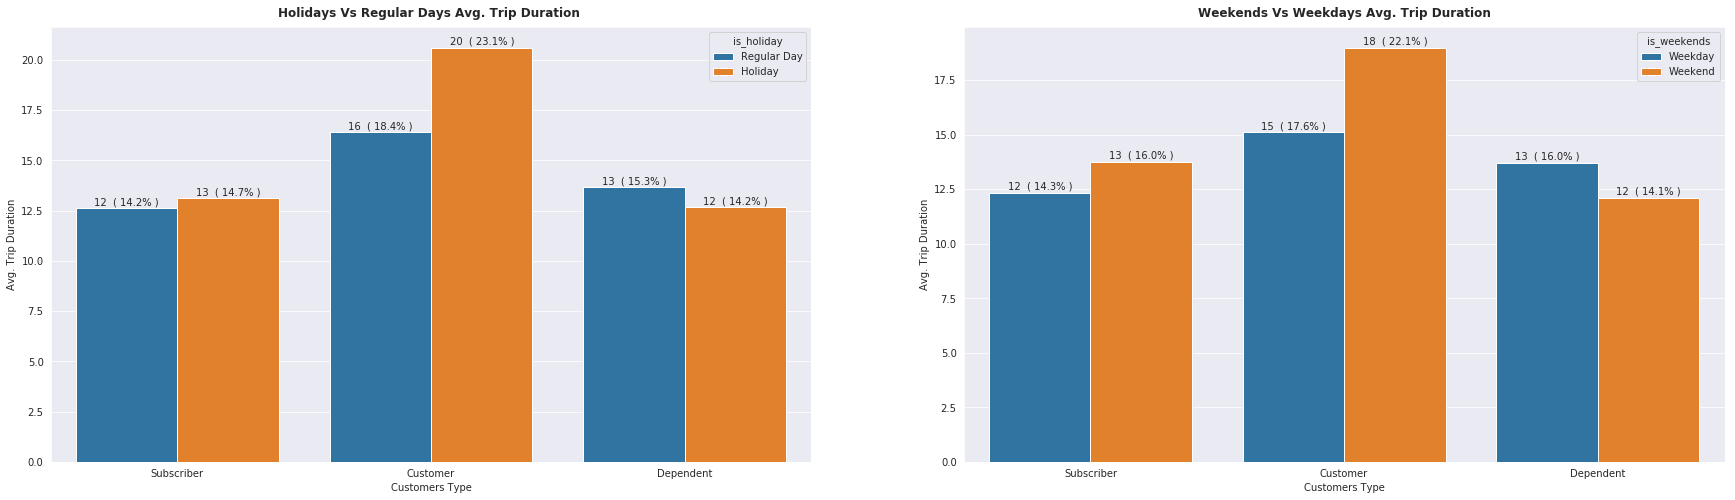

In [33]:
# Aggregate users & holidays 
grouped_users_holidays = df.groupby(['usertype', 'is_holiday'])\
                           .agg({'new_tripduration': lambda x: round(x.mean(),2), 'distance_trip': lambda x: round(x.mean(),2)})\
                           .reset_index().rename(columns = {'new_tripduration': 'mean_tripduration', 'distance_trip': 'mean_tripdistance'})

grouped_users_holidays.usertype.replace(rep_users, inplace = True)
grouped_users_holidays.is_holiday.replace(rep_holidays , inplace = True)

# Aggregate users & weekends
grouped_users_weekends = df.groupby(['usertype', 'is_weekends'])\
                           .agg({'new_tripduration': lambda x: round(x.mean(),2), 'distance_trip': lambda x: round(x.mean(),2)})\
                           .reset_index().rename(columns = {'new_tripduration': 'mean_tripduration', 'distance_trip': 'mean_tripdistance'})

grouped_users_weekends.usertype.replace(rep_users, inplace = True)
grouped_users_weekends.is_weekends.replace(rep_weekends , inplace = True)

# Holidays & weekends average duration plot 
func_barplot_twoplot( x       = [grouped_users_holidays.usertype, grouped_users_weekends.usertype],
                      y       = [grouped_users_holidays.mean_tripduration, grouped_users_weekends.mean_tripduration],
                      hue     = [grouped_users_holidays.is_holiday, grouped_users_weekends.is_weekends],
                      order   = [order_users, order_users],
                      height  = [0.3, 0.3], 
                      total   = [grouped_users_holidays.mean_tripduration.sum(), grouped_users_weekends.mean_tripduration.sum()], 
                      rot     = [None, None], 
                      title   = ['Holidays Vs Regular Days Avg. Trip Duration ', 'Weekends Vs Weekdays Avg. Trip Duration'], 
                      xlabel  = ['Customers Type', 'Customers Type'], 
                      ylabel  = ['Avg. Trip Duration', 'Avg. Trip Duration'],
                      xrot    = [None, None],
                      palette = [None, None])

In [34]:
# Aggregate users & holidays 
grouped_gender_holidays = df.groupby(['gender', 'is_holiday'])\
                           .agg({'new_tripduration': lambda x: round(x.mean(),2), 'distance_trip': lambda x: round(x.mean(),2)})\
                           .reset_index().rename(columns = {'new_tripduration': 'mean_tripduration', 'distance_trip': 'mean_tripdistance'})

grouped_gender_holidays.gender.replace(rep_gender, inplace = True)
grouped_gender_holidays.is_holiday.replace(rep_holidays , inplace = True)

# Aggregate users & weekends
grouped_gender_weekends = df.groupby(['gender', 'is_weekends'])\
                            .agg({'new_tripduration': lambda x: round(x.mean(),2), 'distance_trip': lambda x: round(x.mean(),2)})\
                            .reset_index().rename(columns = {'new_tripduration': 'mean_tripduration', 'distance_trip': 'mean_tripdistance'})

grouped_gender_weekends.gender.replace(rep_gender, inplace = True)
grouped_gender_weekends.is_weekends.replace(rep_weekends , inplace = True)

# Holidays & weekends average duration plot 
func_barplot_twoplot( x       = [grouped_gender_holidays.gender, grouped_gender_weekends.gender],
                      y       = [grouped_gender_holidays.mean_tripduration, grouped_gender_weekends.mean_tripduration],
                      hue     = [grouped_gender_holidays.is_holiday, grouped_gender_weekends.is_weekends],
                      order   = [order_gender, order_gender],
                      height  = [0.3, 0.3], 
                      total   = [grouped_gender_holidays.mean_tripduration.sum(), grouped_gender_weekends.mean_tripduration.sum()], 
                      rot     = [None, None], 
                      title   = ['Holidays Vs Regular Days Avg. Trip Duration ', 'Weekends Vs Weekdays Avg. Trip Duration'], 
                      xlabel  = ['Gender', 'Gender'], 
                      ylabel  = ['Avg. Trip Duration', 'Avg. Trip Duration'],
                      xrot    = [None, None],
                      palette = [None, None])

### Distances Between Stations

In [35]:
group_stations_from = df.groupby(['from_station_name', 'latitude_start', 'longitude_start'])\
                        .agg({'dpcapacity_start': 'min', 'new_tripduration': lambda x: round(x.mean(),2), 'distance_station': lambda x: round(x.mean(),2)})\
                        .reset_index().rename(columns = {'dpcapacity_end': 'from_docks'})

group_stations_end  = df.groupby(['to_station_name', 'latitude_end', 'longitude_end'])\
                        .agg({'dpcapacity_end': 'min', 'new_tripduration': lambda x: round(x.mean(),2), 'distance_station': lambda x: round(x.mean(),2)})\
                        .reset_index().rename(columns = {'dpcapacity_end': 'from_docks'})

crosstabed_stations = pd.crosstab(df.from_station_name, df.to_station_name, normalize = False)

plt.figure(figsize= (40,30))
sns.heatmap(crosstabed_stations, square = True, cmap= 'BuGn')
plt.show()

In [24]:
grouped_hours = df.hour.value_counts().sort_index().reset_index().rename(columns = {'index': 'hours', 'hour': 'counts'})

plt.figure(figsize = (25,8))

_ = sns.barplot(data = grouped_hours, x = 'hours', y = 'counts', palette = 'Paired')
annotate_perct(ax_plot = _, add_height = 100000, total = grouped_hours.counts.sum(), rot= 90)

_.set_title('Number of Trips Based on Hours', pad = 40, weight= 'bold')
_.set_xlabel('Hours')
#_.set_xticklabels(temp_x, rotation = 90)
_.set_ylabel('Trips')
_.margins(0.02)

plt.show()

In [77]:
grouped_hours = df.groupby(['hour', df.is_weekends.replace(rep_weekends)]).size().reset_index().rename(columns = {0: 'counts'})

trace1 = go.Scatter(x = grouped_hours.loc[grouped_hours.is_weekends == 'Weekday', 'hour'],
                    y = grouped_hours.loc[grouped_hours.is_weekends == 'Weekday', 'counts'],
                    name   = 'Weekday',
                    mode   = 'lines+markers')
                    #marker = dict(size = grouped_hours.loc[grouped_hours.is_weekends == 'Weekday', 'counts'] /10000))

trace2 = go.Scatter(x = grouped_hours.loc[grouped_hours.is_weekends == 'Weekend', 'hour'],
                    y = grouped_hours.loc[grouped_hours.is_weekends == 'Weekend', 'counts'],
                    name = 'Weekend',
                    mode  = 'lines+markers')
                    #marker = dict(size = grouped_hours.loc[grouped_hours.is_weekends == 'Weekend', 'counts'] /10000))

# Create layout customization
layout = go.Layout(title = 'Weekends/ Weekdays Trips Based on Hours', 
                   xaxis = dict(title = 'Hours', titlefont = dict(size = 12, color = '#7f7f7f')),
                   yaxis = dict(title = 'Trips', titlefont = dict(size = 12, color = '#7f7f7f')))

# Prepare and plot the chart
fig = go.Figure(data = [trace1, trace2], layout = layout)
iplot(fig)

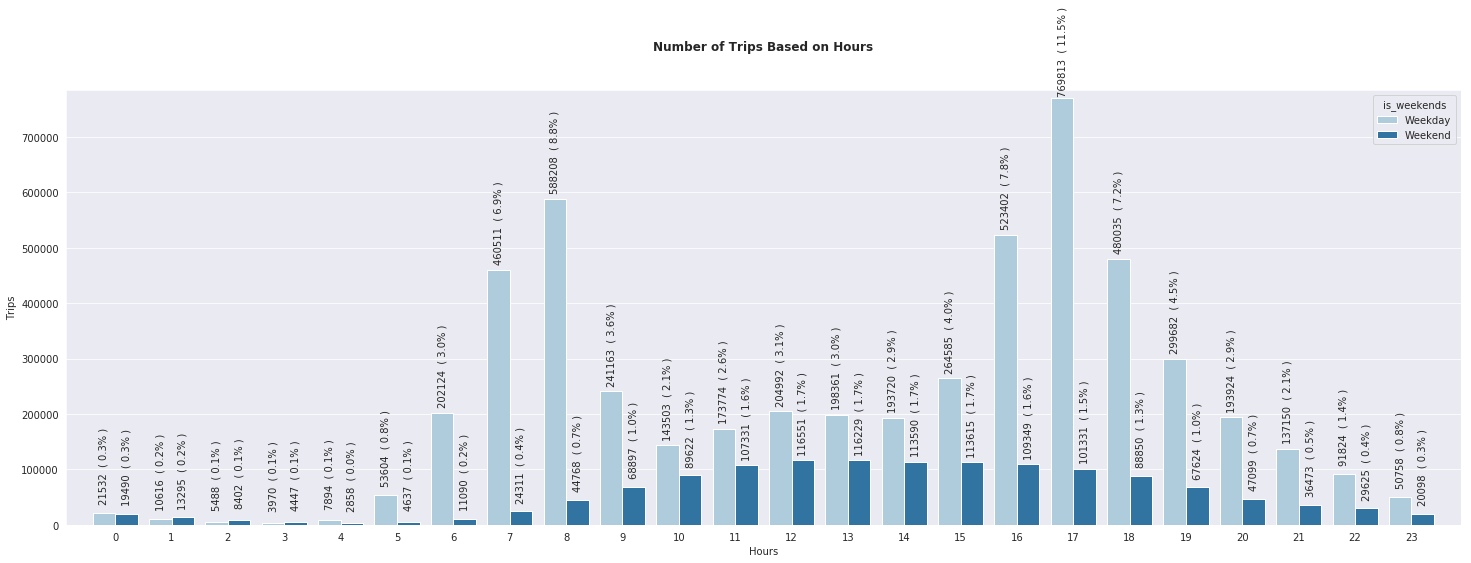

In [72]:
plt.figure(figsize = (25,8))

_ = sns.barplot(data = grouped_hours, x = 'hour', y = 'counts', hue = 'is_weekends', palette = 'Paired')
annotate_perct(ax_plot = _, add_height = 85000, total = grouped_hours.counts.sum(), rot= 90)

_.set_title('Number of Trips Based on Hours', pad = 40, weight= 'bold')
_.set_xlabel('Hours')
#_.set_xticklabels(temp_x, rotation = 90)
_.set_ylabel('Trips')
_.margins(0.02)

plt.show()

In [36]:
grouped_hours = df.groupby(['hour']).agg({'new_tripduration': lambda x: round(x.mean(),2), 
                                          'distance_trip'   : lambda x: round(x.mean(),2),
                                          'starttime'       : 'count'})\
                                    .reset_index()\
                                    .rename(columns = {'new_tripduration': 'mean_tripduration', 
                                                       'distance_trip': 'mean_tripdistance',
                                                       'starttime': 'counts'})

grouped_hours.head()

hour  mean_tripduration  mean_tripdistance  counts
0     0              12.45               2.24   41022
1     1              12.43               2.25   23911
2     2              12.38               2.26   13890
3     3              12.23               2.31    8417
4     4              12.59               2.61   10752

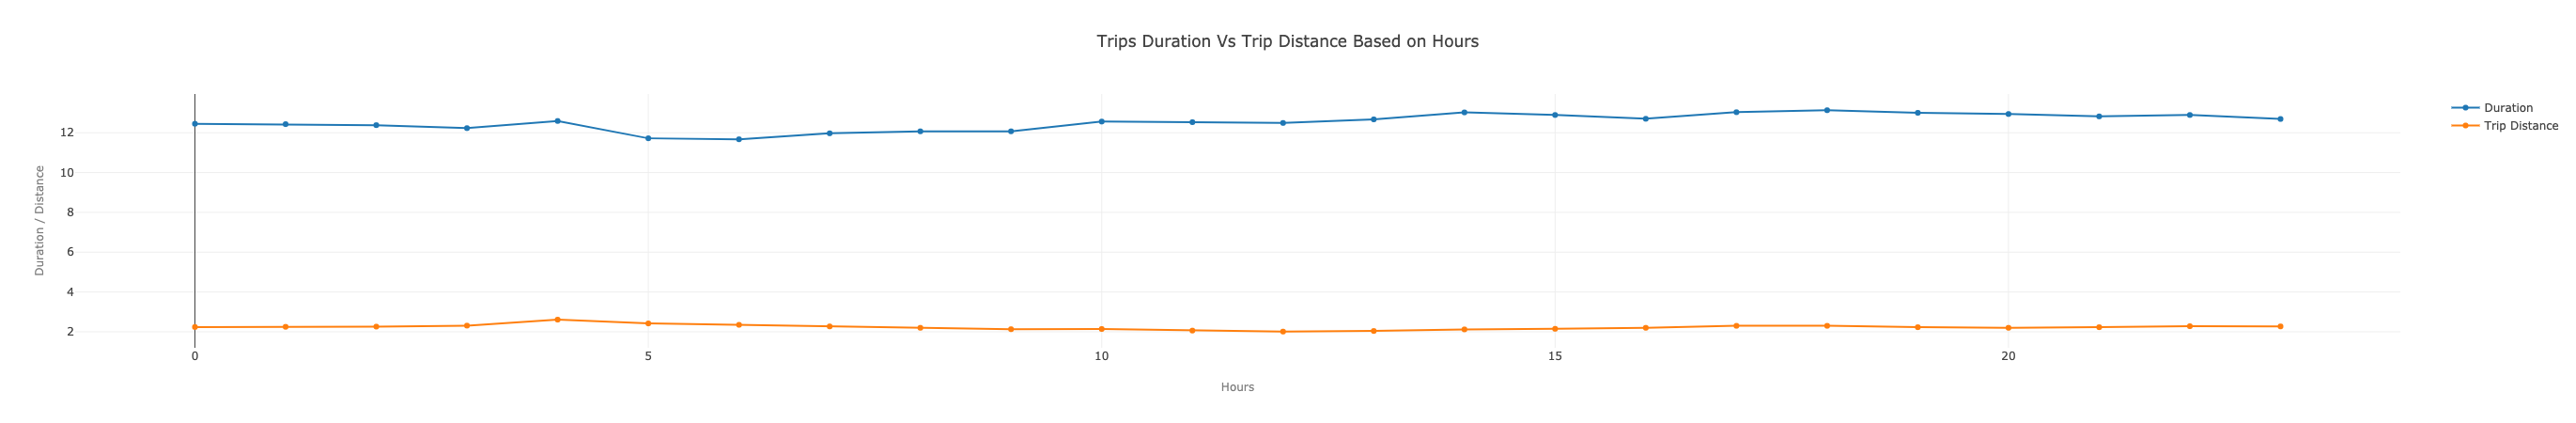

In [37]:

trace1 = go.Scatter(x = grouped_hours.hour,
                    y = grouped_hours.mean_tripduration,
                    name   = 'Duration',
                    mode   = 'lines+markers')
                    #marker = dict(size = grouped_hours.loc[grouped_hours.is_weekends == 'Weekday', 'counts'] /10000))

trace2 = go.Scatter(x = grouped_hours.hour,
                    y = grouped_hours.mean_tripdistance,
                    name = 'Trip Distance',
                    mode  = 'lines+markers')
                    #marker = dict(size = grouped_hours.loc[grouped_hours.is_weekends == 'Weekend', 'counts'] /10000))

# Create layout customization
layout = go.Layout(title = 'Trips Duration Vs Trip Distance Based on Hours', 
                   xaxis = dict(title = 'Hours', titlefont = dict(size = 12, color = '#7f7f7f')),
                   yaxis = dict(title = 'Duration / Distance', titlefont = dict(size = 12, color = '#7f7f7f')))

# Prepare and plot the chart
fig = go.Figure(data = [trace1, trace2], layout = layout)
iplot(fig)

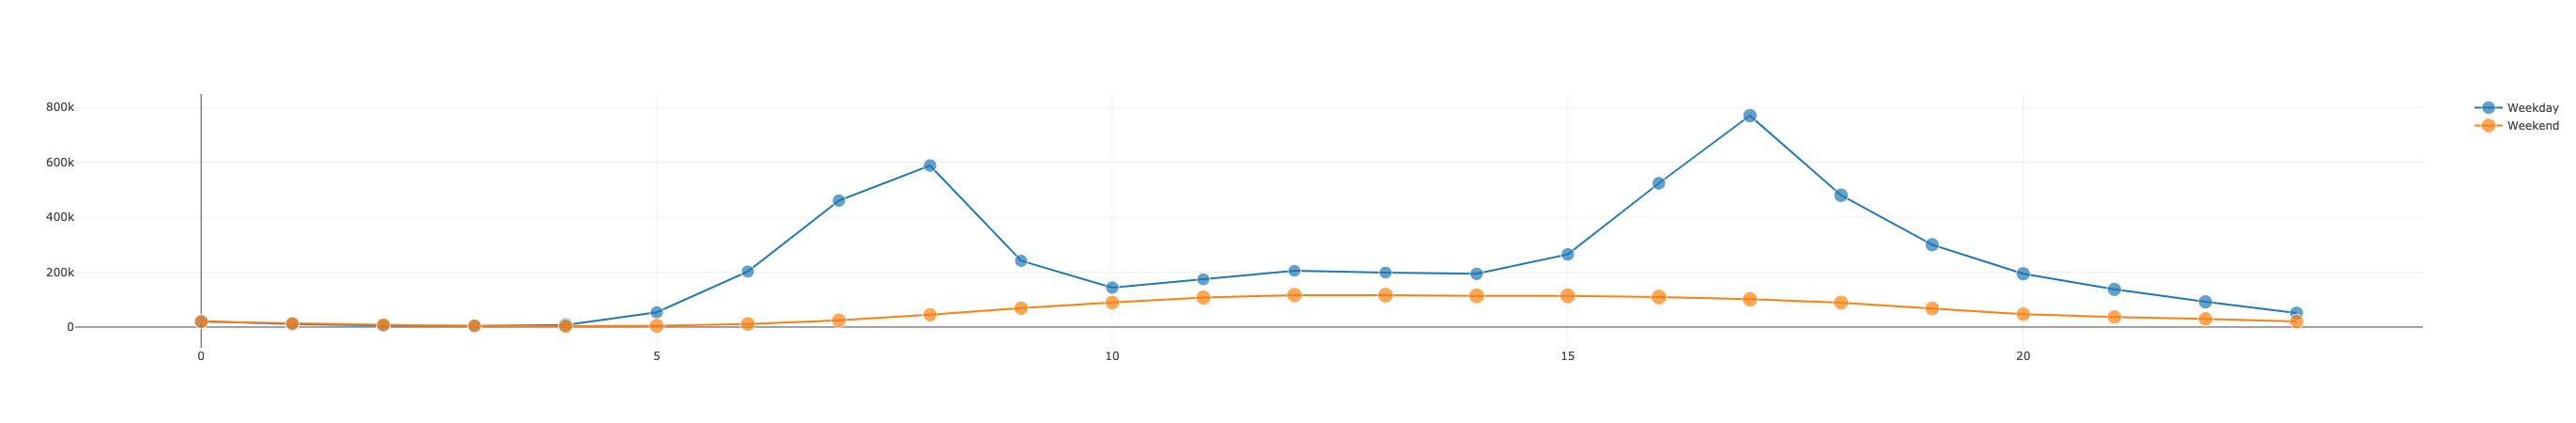

In [41]:
grouped_hours = df.groupby(['hour', 'is_weekends']).agg({'new_tripduration': lambda x: round(x.mean(),2), 
                                                         'distance_trip'    : lambda x: round(x.mean(),2),
                                                         'starttime'       : 'count'})\
                                                   .reset_index()\
                                                   .rename(columns = {'new_tripduration': 'mean_tripduration', 
                                                                      'distance_trip': 'mean_tripdistance',
                                                                      'starttime': 'counts'})

grouped_hours.is_weekends.replace(rep_weekends, inplace = True)

traces = []

for name, weekend in grouped_hours.groupby(['is_weekends']):
    traces.append(go.Scatter(x = weekend.hour, 
                             y = weekend.counts , 
                             text = 'Duration: ' + weekend.mean_tripduration.astype('str') + '<br>' + 'Distance: ' + weekend.mean_tripdistance.astype('str'), 
                             name = name, 
                             mode = 'lines+markers',
                             marker = dict(size = weekend.mean_tripduration + weekend.mean_tripdistance)))
    
# Prepare and plot the chart
fig = go.Figure(data=traces)
iplot(fig)

In [134]:
df.groupby(['hour', 'is_weekends']).agg({'new_tripduration': lambda x: round(x.mean(),2), 
                                                         'distance'        : lambda x: round(x.mean(),2),
                                                         'starttime'       : 'count',
                                                         'temperature'     : lambda x: round(x.mean(),2)})\
                                                   .reset_index()\
                                                   .rename(columns = {'new_tripduration': 'mean_tripduration', 
                                                                      'distance': 'mean_distance',
                                                                      'starttime': 'counts'})

hour  is_weekends  mean_tripduration  mean_distance  counts  temperature
0      0        False              12.39           2.21   21532        14.93
1      0         True              12.52           2.19   19490        15.02
2      1        False              12.60           2.21   10616        14.44
3      1         True              12.29           2.19   13295        14.36
4      2        False              12.53           2.25    5488        13.85
5      2         True              12.28           2.19    8402        13.91
6      3        False              12.40           2.36    3970        13.16
7      3         True              12.07           2.18    4447        13.73
8      4        False              12.58           2.61    7894        11.99
9      4         True              12.61           2.38    2858        13.70
10     5        False              11.60           2.38   53604        12.37
11     5         True              13.20           2.58    4637        13.76
12     6        False              11.59           2.32  202124        12.81
13     6         True              13.07           2.45   11090        13.97
14     7        False              11.91           2.25  460511        13.74
15     7         True              13.00           2.35   24311        14.70
16     8        False              12.02           2.18  588208        14.57
17     8         True              12.71           2.25   44768        16.10
18     9        False              11.80           2.06  241163        15.95
19     9         True              13.02           2.23   68897        17.45
20    10        False              12.10           2.03  143503        17.59
21    10         True              13.31           2.20   89622        18.79
22    11        False              11.78           1.88  173774        18.69
23    11         True              13.75           2.21  107331        19.65
24    12        False              11.63           1.81  204992        19.56
25    12         True              14.00           2.21  116551        20.34
26    13        False              11.73           1.86  198361        19.83
27    13         True              14.29           2.22  116229        20.98
28    14        False              12.22           1.98  193720        19.95
29    14         True              14.39           2.22  113590        21.05
30    15        False              12.21           2.05  264585        19.39
31    15         True              14.48           2.24  113615        20.83
32    16        False              12.36           2.16  523402        18.75
33    16         True              14.31           2.22  109349        20.73
34    17        False              12.90           2.29  769813        18.45
35    17         True              14.03           2.19  101331        20.45
36    18        False              13.02           2.28  480035        18.35
37    18         True              13.70           2.17   88850        19.90
38    19        False              12.90           2.20  299682        18.00
39    19         True              13.44           2.11   67624        19.15
40    20        False              12.90           2.17  193924        17.48
41    20         True              13.11           2.07   47099        18.45
42    21        False              12.76           2.21  137150        16.57
43    21         True              13.03           2.12   36473        17.62
44    22        False              12.80           2.26   91824        16.35
45    22         True              13.16           2.20   29625        16.97
46    23        False              12.60           2.24   50758        15.67
47    23         True              12.91           2.20   20098        16.10

In [42]:
df.new_tripduration.mean()

12.62625963385909

In [48]:
duration_mean        = round(df.new_tripduration.mean(), 2)
duration_mean_2015   = round(df.loc[(df.year == 2015), 'new_tripduration'].mean(), 2)
duration_mean_2016   = round(df.loc[(df.year == 2016), 'new_tripduration'].mean(), 2)
duration_mean_2017   = round(df.loc[(df.year == 2017), 'new_tripduration'].mean(), 2)
duration_mean_201701 = round(df.loc[(df.year == 2017) & (df.month == 1), 'new_tripduration'].mean(), 2)

#January 2017 Average Trip Duration is 11.07

# Group & Aggregate data  
JAN2017 = df.loc[(df.year == 2017) & (df.month == 1)]\
            .groupby([df.starttime.dt.date, 'is_weekends', 'is_holiday'])\
            .agg({'new_tripduration': lambda x: (round(x.mean(), 2) - duration_mean_201701)})\
            .reset_index()\
            .rename(columns = { 'starttime': 'date', 'new_tripduration': 'mean_tripduration' })

JAN2017.is_weekends.replace(rep_weekends, inplace = True)
JAN2017.is_holiday.replace(rep_holidays, inplace = True)

# Prepare color codes and x axis labels
color_code = ['blue' if round(val, 2) > 0 else 'red' for val in JAN2017.mean_tripduration]
dates_code = [str(val) for val in JAN2017.date]

# Create plotly graph
data = [go.Bar(x = JAN2017.date, y = JAN2017.mean_tripduration, text = JAN2017.is_weekends + '<br>' + JAN2017.is_holiday, marker = dict(color = color_code))]

layout = go.Layout(title = 'January 2017 Daily Trip Duration Compared with January 2017 Average Trip Duration', 
                   xaxis = dict(tickvals = dates_code, tickangle = -90),
                   yaxis = dict(title = 'Average Trip Duration', titlefont = dict(size = 12, color = '#7f7f7f')))


fig = go.Figure(data = data, layout = layout)
iplot(fig)

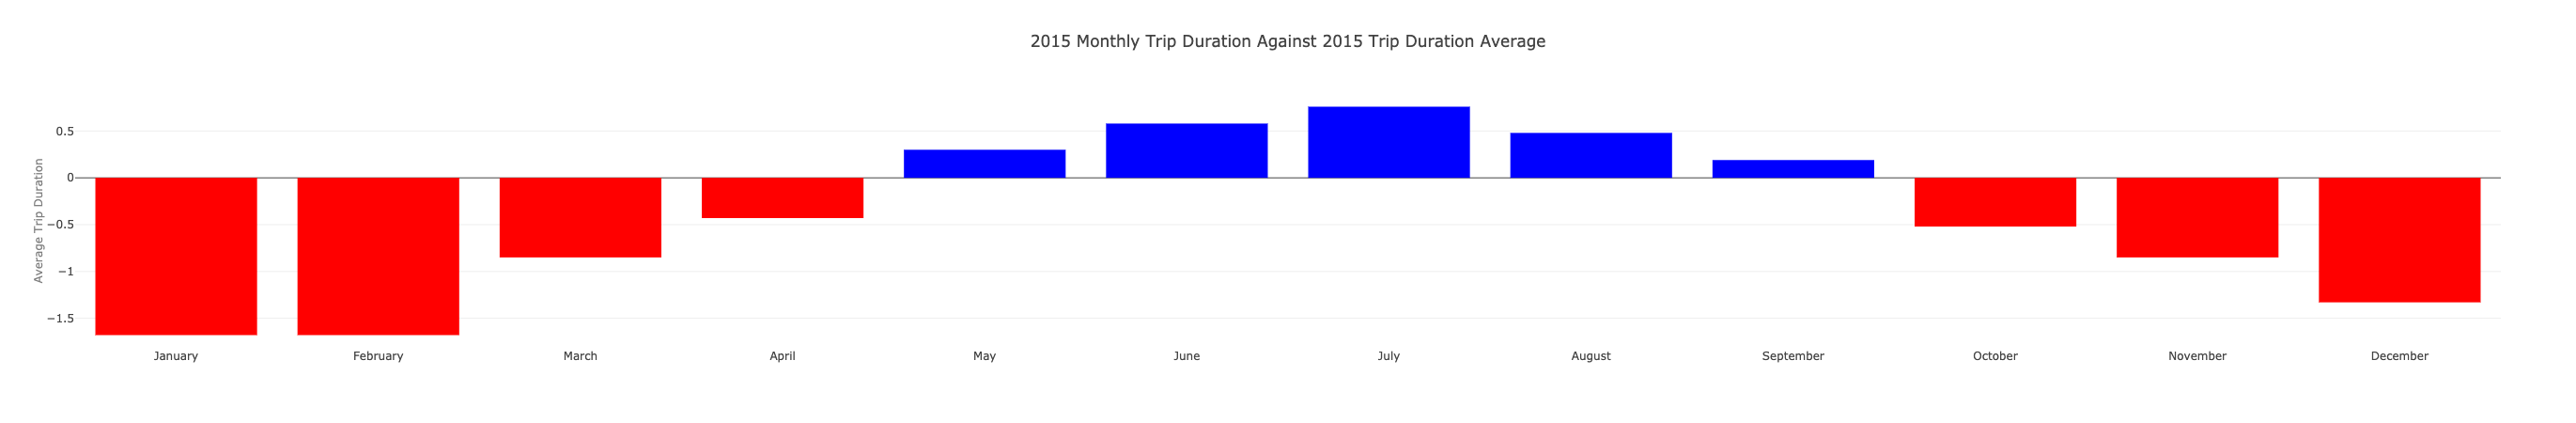

In [52]:
# Group & Aggregate data  
months2015 = df.loc[df.year == 2015].groupby(['month'])\
                                    .agg({'new_tripduration': lambda x: (round(x.mean(),2) - duration_mean_2015)})\
                                    .reset_index()\
                                    .rename(columns = { 'new_tripduration': 'mean_tripduration' })

months2015.month.replace(rep_months, inplace = True)

# Prepare color codes and x axis labels
color_code = ['blue' if round(val, 2) > 0 else 'red' for val in months2015.mean_tripduration]

# Create plotly graph
data = [go.Bar(x = months2015.month, y = months2015.mean_tripduration, marker = dict(color = color_code))]

layout = go.Layout(title = '2015 Monthly Trip Duration Against 2015 Trip Duration Average', 
                   yaxis = dict(title = 'Average Trip Duration', titlefont = dict(size = 12, color = '#7f7f7f')))


fig = go.Figure(data = data, layout = layout)
iplot(fig)

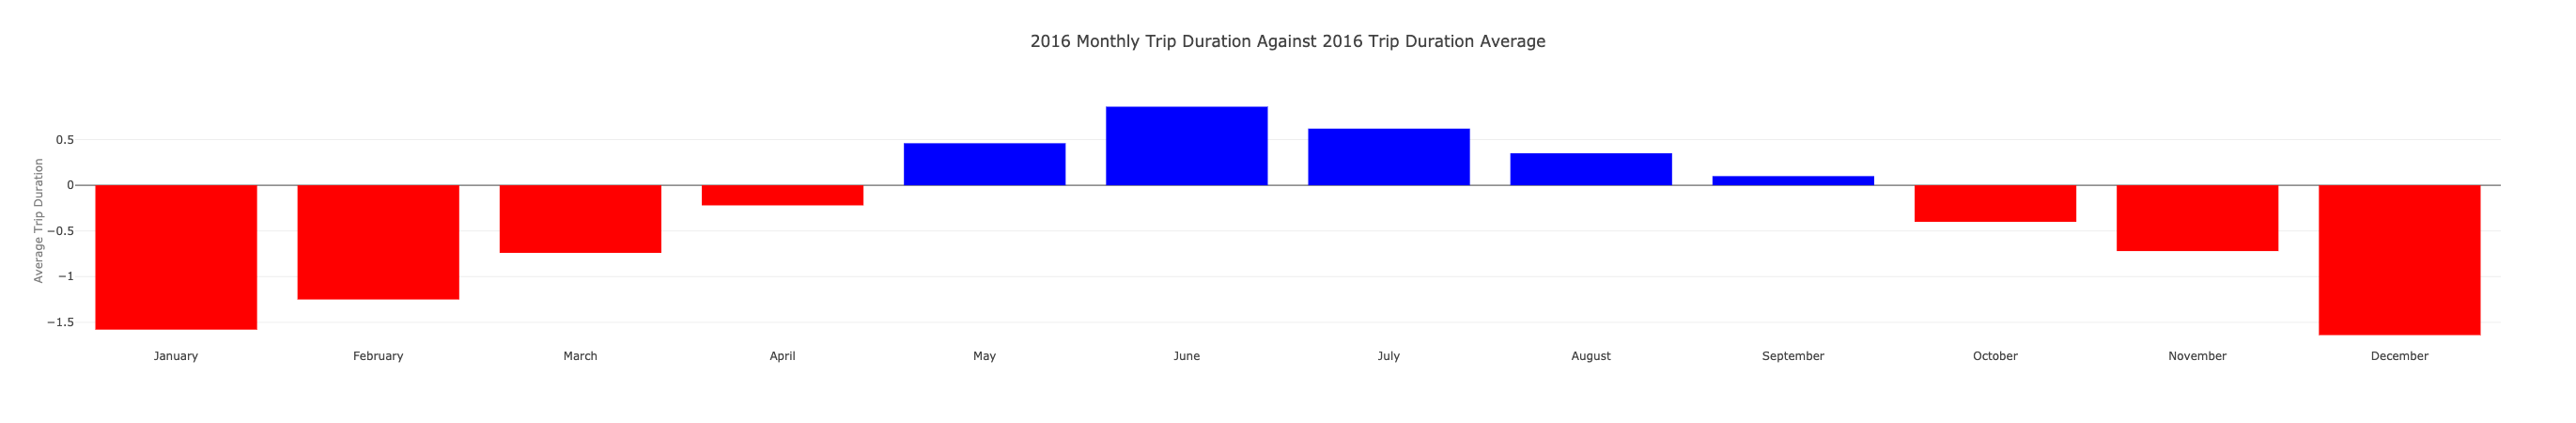

In [53]:
# Group & Aggregate data  
months2016 = df.loc[df.year == 2016].groupby(['month'])\
                                    .agg({'new_tripduration': lambda x: (round(x.mean(),2) - duration_mean_2016)})\
                                    .reset_index()\
                                    .rename(columns = { 'new_tripduration': 'mean_tripduration' })

months2016.month.replace(rep_months, inplace = True)

# Prepare color codes and x axis labels
color_code = ['blue' if round(val, 2) > 0 else 'red' for val in months2016.mean_tripduration]

# Create plotly graph
data = [go.Bar(x = months2016.month, y = months2016.mean_tripduration, marker = dict(color = color_code))]

layout = go.Layout(title = '2016 Monthly Trip Duration Against 2016 Trip Duration Average', 
                   yaxis = dict(title = 'Average Trip Duration', titlefont = dict(size = 12, color = '#7f7f7f')))


fig = go.Figure(data = data, layout = layout)
iplot(fig)

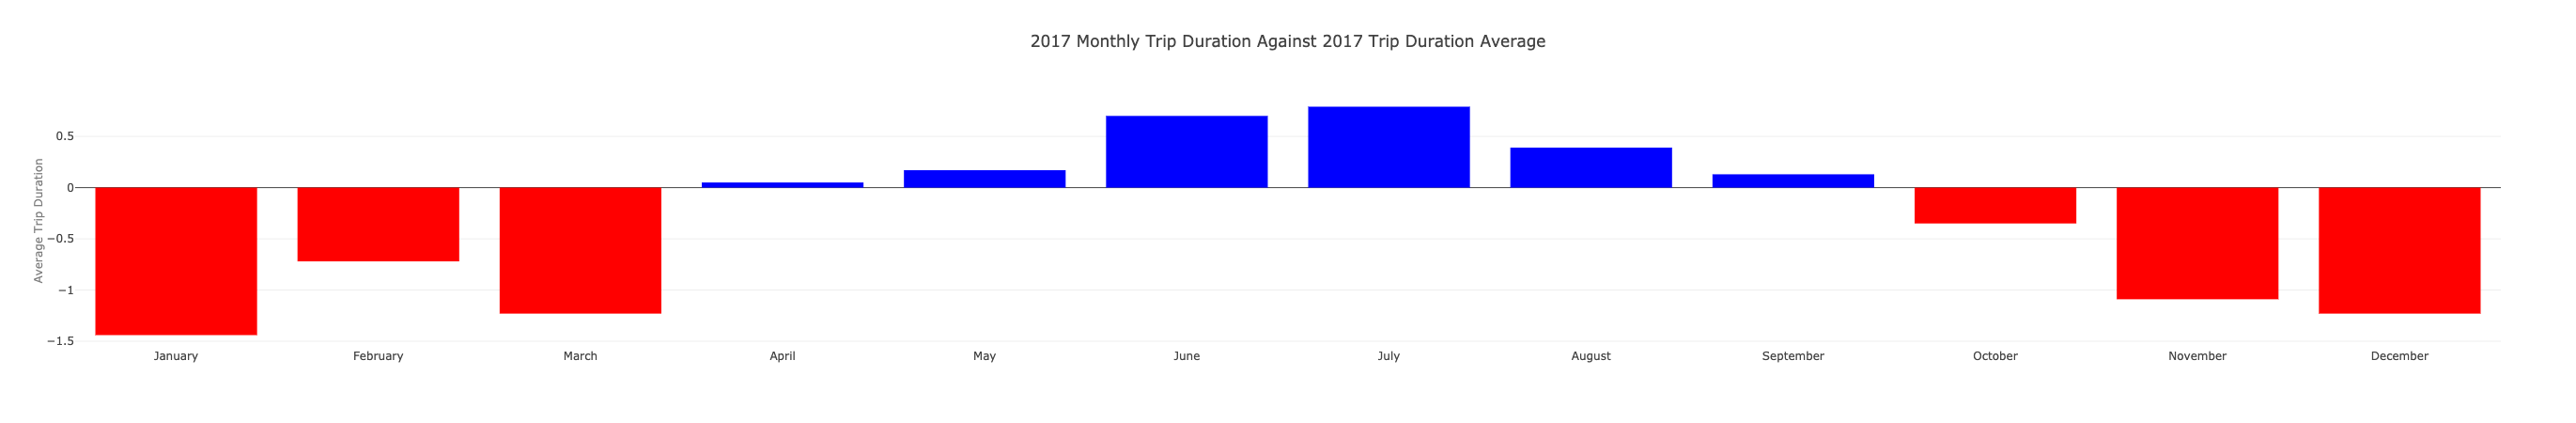

In [54]:
# Group & Aggregate data  
months2017 = df.loc[df.year == 2017].groupby(['month'])\
                                    .agg({'new_tripduration': lambda x: (round(x.mean(),2) - duration_mean_2017)})\
                                    .reset_index()\
                                    .rename(columns = { 'new_tripduration': 'mean_tripduration' })

months2017.month.replace(rep_months, inplace = True)

# Prepare color codes and x axis labels
color_code = ['blue' if round(val, 2) > 0 else 'red' for val in months2017.mean_tripduration]

# Create plotly graph
data = [go.Bar(x = months2017.month, y = months2017.mean_tripduration, marker = dict(color = color_code))]

layout = go.Layout(title = '2017 Monthly Trip Duration Against 2017 Trip Duration Average', 
                   yaxis = dict(title = 'Average Trip Duration', titlefont = dict(size = 12, color = '#7f7f7f')))


fig = go.Figure(data = data, layout = layout)
iplot(fig)

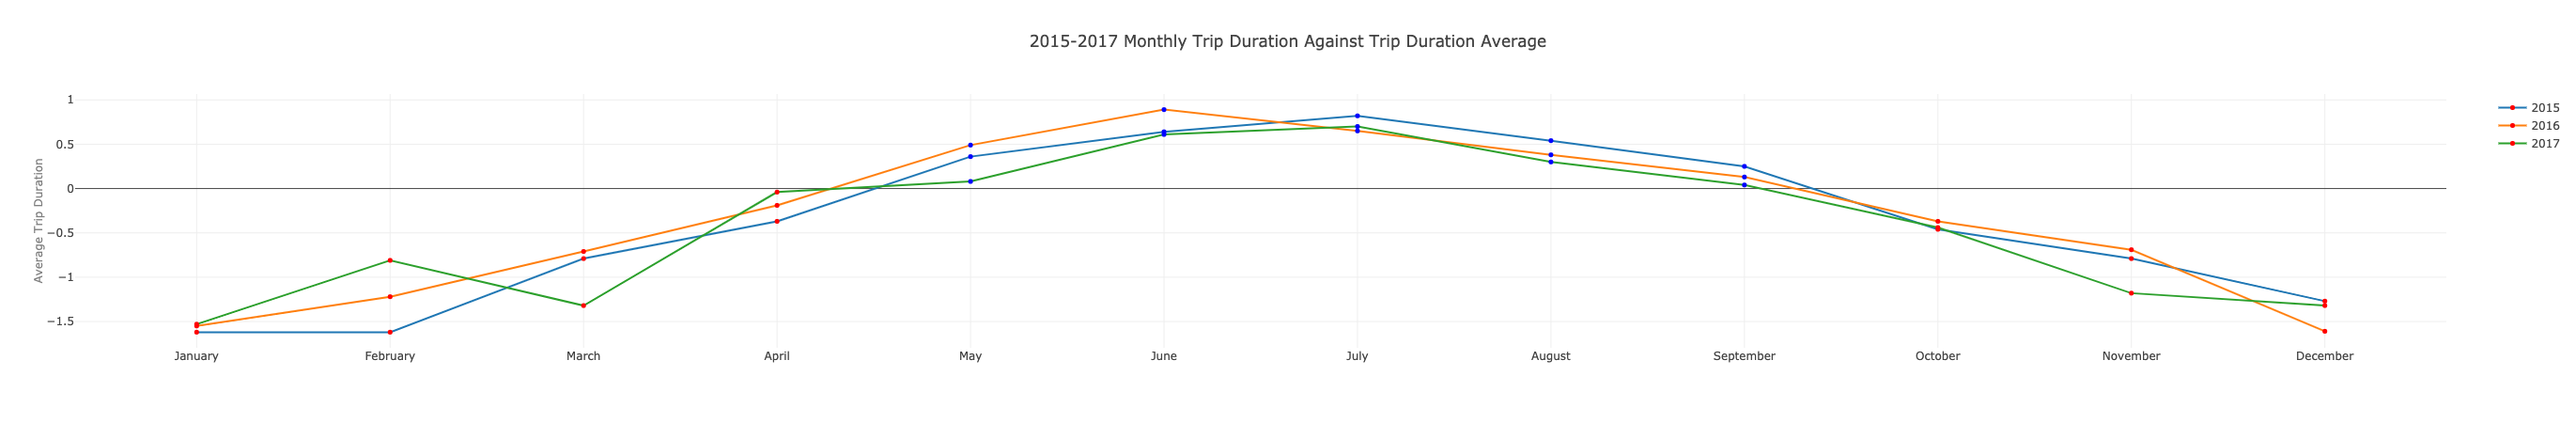

In [55]:
allmonths = df.groupby(['year', 'month'])\
              .agg({'new_tripduration': lambda x: (round(x.mean(),2) - duration_mean)})\
              .reset_index()\
              .rename(columns = { 'new_tripduration': 'mean_tripduration' })

allmonths.month.replace(rep_months, inplace = True)
allmonths['color'] = allmonths.mean_tripduration.apply(lambda x: 'blue' if round(x, 2) > 0 else 'red')


traces_list = []

for yr, gr in allmonths.groupby('year'):
    traces_list.append(go.Scatter(x = gr.month, y = gr.mean_tripduration, name = yr, mode = 'lines+markers', marker = dict(size = 5, color = gr.color)))
    
layout = go.Layout(title = '2015-2017 Monthly Trip Duration Against Trip Duration Average', 
                   yaxis = dict(title = 'Average Trip Duration', titlefont = dict(size = 12, color = '#7f7f7f')))

fig = go.Figure(data = traces_list, layout = layout)
iplot(fig)

In [90]:
df.to_pickle('df_features_latest.pickle')